In [9]:
import os
use_gpu = '5' # kimbg
os.environ["CUDA_VISIBLE_DEVICES"] = use_gpu 
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

import torch
import pandas as pd

In [12]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
amp_scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


interest_windows = [3,7,14,30,90]  # [3,7,14,30,90,180,365]
add_status = True
target_cols = {'input':'bpf0540_or3-npy_path',}
target_class_list = ['AFIB_AFL-keyword_v2', 'CIA-keyword_v2']
target_cols['label'] = []
for window in interest_windows:
    for target_class in target_class_list:
        target_cols['label'] += [f'ECG_event_{window}d_{target_class}_onset']
if add_status: 
    target_cols['label'] += target_class_list[:]
filter_col = 'ECG_event_14d_CIA-keyword_v2_onset'
target_cls_idx = [target_cols['label'].index(filter_col)-1, target_cols['label'].index(filter_col)]
# subset_cols = [target_cols['input']] + ['kfold']
# subset_cols += target_cols['label']


def df_read_and_filtering(df_path, filter_col, prefix = None):
    df = pd.read_csv(df_path)
    print(f'Original {prefix} dataframe shape : {df.shape}')
    con = (df[filter_col].isin([0,1]))
    df = df[con].reset_index(drop=True).copy()
    print(f'Filtered {prefix} dataframe shape : {df.shape}') 
    return df

eumc_df_path = '/mnt/home/Datasets_processed/EKG_Latest/processed_metadata_v6-sv2_subset_2_holdout.csv'
eumc_df = df_read_and_filtering(eumc_df_path, filter_col, prefix = 'EUMC-tst-set')
eumc_df['bpf0540_or3-npy_path_v2'] = list(map(lambda x:'/mnt'+x, eumc_df['bpf0540_or3-npy_path']))
target_cols['input'] = 'bpf0540_or3-npy_path_v2'


### check ###
print('device', device)
print('amp_scaler', amp_scaler)
print('target_cols', target_cols)

/tmp/ipykernel_3113274/3795369942.py:23: DtypeWarning: Columns (4,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_path)


Original EUMC-tst-set dataframe shape : (69342, 291)
Filtered EUMC-tst-set dataframe shape : (15190, 291)
device cpu
amp_scaler <torch.cuda.amp.grad_scaler.GradScaler object at 0x7f9b9aab82e0>
target_cols {'input': 'bpf0540_or3-npy_path_v2', 'label': ['ECG_event_3d_AFIB_AFL-keyword_v2_onset', 'ECG_event_3d_CIA-keyword_v2_onset', 'ECG_event_7d_AFIB_AFL-keyword_v2_onset', 'ECG_event_7d_CIA-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_30d_AFIB_AFL-keyword_v2_onset', 'ECG_event_30d_CIA-keyword_v2_onset', 'ECG_event_90d_AFIB_AFL-keyword_v2_onset', 'ECG_event_90d_CIA-keyword_v2_onset', 'AFIB_AFL-keyword_v2', 'CIA-keyword_v2']}


In [13]:
eumc_df = eumc_df[:2]
eumc_df

,path,error,pid,name,age,sex,date,time,rate,hr,...,ECG_event_365d_AA-keyword_v2_episode,ECG_event_365d_VP-keyword_v2_episode,ECG_event_365d_BBB-keyword_v2_episode,pid_weight,pid_log_weight,bpf0540_or3-npy_path,file,machine,kfold,bpf0540_or3-npy_path_v2
0,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10302870.0,NaN,68,Male,2023-10-17,15:52:13,500.0,57.0,...,0,0,0,0.142857,0.480898,/home/Datasets_processed/EKG_Latest/signal-bpf...,10302870_2023-10-17_2023101716092374_202310171...,philips,3,/mnt/home/Datasets_processed/EKG_Latest/signal...
1,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10203160.0,NaN,77,Unknown,2023-10-04,11:31:40,500.0,67.0,...,0,0,0,0.166667,0.513898,/home/Datasets_processed/EKG_Latest/signal-bpf...,10203160_2023-10-04_2023100411441625_202310111...,philips,5,/mnt/home/Datasets_processed/EKG_Latest/signal...


In [14]:
class CFG:
    TARGET_COLS = target_cols
    MODEL_INFO = {
        'config':{
            'embed_dim':768,  
            'patch_size':32, 
            'seq_length':2560,
            'in_channels':12, 
            'encoder':'vit_encoder',
            'merge_mode':'projection',  
            'num_classes':len(target_cols['label']),
        },        
        'model_path_list': [
            '/mnt/home/bgk/macai-model-experimental/_kimbg_code/SynAI_v2/outputs/checkpoint/CL_step3-TRN-MacAI_v1_2-0819 copy 21/0fold/Best_AUPRC-Ep_3-Lo_0.082-M0_0.793-M1_0.494.pth',
            '/mnt/home/bgk/macai-model-experimental/_kimbg_code/SynAI_v2/outputs/checkpoint/CL_step3-TRN-MacAI_v1_2-0819 copy 21/0fold/Best_AUROC-Ep_7-Lo_0.082-M0_0.800-M1_0.493.pth',
            '/mnt/home/bgk/macai-model-experimental/_kimbg_code/SynAI_v2/outputs/checkpoint/CL_step3-TRN-MacAI_v1_2-0819 copy 21/0fold/Best_loss-Ep_5-Lo_0.082-M0_0.797-M1_0.493.pth',
        ],
    }

In [15]:
from model_architecture import SynAI

def model_build(model_info):
    model = SynAI.MAE_1D_250409_v3(
        seq_length  = model_info['seq_length'],
        in_channels = model_info['in_channels'],
        patch_size  = model_info['patch_size'],
        embed_dim   = model_info['embed_dim'],
        merge_mode  = model_info['merge_mode'],  # linear_projection avg add
        encoder     = model_info['encoder'],
    )
    model = SynAI.OnlyEncoderForFT_250409(
        model,
        num_classes = model_info['num_classes'],
        embed_dim = model_info['embed_dim'],
    )
    return model

def load_models(model_path_list, model_info, device='cpu'):
    models = []
    for model_path in model_path_list:
        checkpoint = torch.load(model_path, weights_only=True)
        model = model_build(model_info).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        models.append({'model_path': model_path, 'model': model})
    return models

models = load_models(CFG.MODEL_INFO['model_path_list'], CFG.MODEL_INFO['config'], device=device)

### Check loaded models
# for idx, m in enumerate(models):
#     param_list = [p.detach().cpu().numpy() for p in m['model'].parameters()]
#     print(f"Model {idx} - First param sum: {param_list[0].sum():.6f}")

/home/syai-research/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


seq_length 2560, in_channels 12, patch_size 32, embed_dim 768, token_len 80, 
seq_length 2560, in_channels 12, patch_size 32, embed_dim 768, token_len 80, 
seq_length 2560, in_channels 12, patch_size 32, embed_dim 768, token_len 80, 


In [16]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from scipy.signal import resample
from typing import Optional, Iterable, Dict, Any, Callable, List

# --- 최종 개선된 ECG Dataset 클래스 ---
class ECGDataset(Dataset):
    """
    다양한 소스(파일 경로 리스트, 데이터프레임 등)로부터 ECG 데이터셋을 생성할 수 있는
    유연한 PyTorch Dataset 클래스입니다.
    """
    _LEAD_SLICE = {
        "12lead": slice(0, 12),
        "limb_lead": slice(0, 6),
        "lead1": slice(0, 1),
        "lead2": slice(1, 2)
    }
    
    # --- 핵심 로직: 스태틱 메소드 (v3와 동일) ---
    @staticmethod
    def load_ecg(fpath: str) -> np.ndarray:
        # ... (이전과 동일) ...
        _, ext = os.path.splitext(fpath)
        ext = ext.lower()
        if ext == '.pkl':
            with open(fpath, 'rb') as f:
                return pkl.load(f)
        elif ext == '.npy':
            return np.load(fpath)
        else:
            raise ValueError(f"지원하지 않는 파일 형식입니다: {ext}")

    @staticmethod
    def preprocess_ecg(
        x: np.ndarray,
        target_lead: str,
        target_len: int,
        do_resample: bool = True,
        do_normalize: bool = True,
        transforms: Optional[Callable] = None,
    ) -> np.ndarray:
        # ... (이전과 동일) ...
        assert target_lead in ECGDataset._LEAD_SLICE, \
            f"target_lead는 다음 중 하나여야 합니다: {list(ECGDataset._LEAD_SLICE.keys())}"
        lead_slice = ECGDataset._LEAD_SLICE[target_lead]
        x = x[lead_slice, :]
        assert x.shape[0] < x.shape[1], \
            f"데이터 형식이 (seq_len, leads)일 수 있습니다. (leads, seq_len)으로 변경해야 합니다. 현재 shape: {x.shape}"
        if do_resample and x.shape[-1] != target_len:
            x = resample(x, target_len, axis=-1).astype(np.float32)
        if do_normalize:
            clipped_x = np.clip(x, np.percentile(x, 1), np.percentile(x, 99))
            mu = np.median(x, axis=-1, keepdims=True)
            sigma = np.std(clipped_x, axis=-1, keepdims=True)
            x = (x - mu) / (sigma + 1e-8)
        if transforms:
            x = transforms(x)
        return x.astype(np.float32)

    # --- 기본 생성자: 이제 파일 경로 리스트를 직접 받음 ---
    def __init__(self,
                 file_paths: List[str],
                 labels: Optional[List[Any]] = None,
                 target_lead: str = "12lead",
                 target_len: int = 2560,
                 do_resample: bool = True,
                 do_normalize: bool = True,
                 transforms: Optional[Callable] = None,
                 label_transforms: Optional[Callable] = None):
        
        self.file_paths = file_paths
        self.labels = labels
        
        if self.labels is not None:
            assert len(self.file_paths) == len(self.labels), "입력(file_paths)과 레이블(labels)의 개수가 일치해야 합니다."
        
        self.target_lead = target_lead
        self.target_len = target_len
        self.do_resample = do_resample
        self.do_normalize = do_normalize
        self.transforms = transforms
        self.label_transforms = label_transforms
    
    # --- 클래스 메소드 팩토리: 데이터프레임으로부터 클래스 인스턴스 생성 ---
    @classmethod
    def from_dataframe(cls, 
                       df: pd.DataFrame, 
                       input_col: str, 
                       label_col: Optional[Iterable] = None,
                       **kwargs):
        """
        Pandas DataFrame에서 파일 경로와 레이블을 추출하여
        ECGDataset 인스턴스를 생성하는 팩토리 메소드입니다.
        """
        file_paths = df[input_col].values.tolist()
        labels = df[label_col].values.tolist() if label_col else None
        
        # cls는 ECGDataset 클래스 자신을 의미합니다.
        # **kwargs를 통해 target_lead, target_len 등의 추가 인자를 전달합니다.
        return cls(file_paths=file_paths, labels=labels, **kwargs)

    def __len__(self) -> int:
        return len(self.file_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        fpath = self.file_paths[idx]
        x = self.load_ecg(fpath)
        x = self.preprocess_ecg(
            x=x,
            target_lead=self.target_lead,
            target_len=self.target_len,
            do_resample=self.do_resample,
            do_normalize=self.do_normalize,
            transforms=self.transforms,
        )
        output = {'input': torch.from_numpy(x), 'input_path': fpath}
        
        if self.labels is not None:
            y = self.labels[idx]
            if self.label_transforms:
                y = self.label_transforms(y)
            y = torch.as_tensor(y, dtype=torch.float32)
            output['label'] = y.squeeze()

        return output

In [17]:
from torch.utils.data import DataLoader
from processing import transforms

transform_pipeline = {}
transform_pipeline['val'] = transforms.TransformPipeline([
    transforms.NormalizeECG(method="tanh", scope="lead-wise", scale=1),
])

eumc_ds = ECGDataset.from_dataframe(
    df = eumc_df,
    input_col     = CFG.TARGET_COLS['input'],
    label_col     = CFG.TARGET_COLS['label'],
    target_lead   = '12lead',
    target_len    = 2560,
    transforms    = transform_pipeline['val'],
    do_normalize  = False,
)
eumc_dl        = DataLoader(
    dataset    = eumc_ds,
    batch_size = 512,
    shuffle    = False,
    drop_last  = False,
)

In [18]:
import torch
from typing import Dict, Optional, List
from torch.utils.data import DataLoader
from tqdm import tqdm

@torch.no_grad()
def inference_tensor(
    model: torch.nn.Module,
    input_tensor: torch.Tensor,
    activation: Optional[str] = 'sigmoid',
    to_cpu: bool = True
) -> Dict[str, torch.Tensor]:
    """
    단일 샘플 또는 배치 텐서에 대해 추론 결과 반환
    """
    original_input = input_tensor.clone().detach()
    device = next(model.parameters()).device
    model.eval()
    inference_input = input_tensor.to(device)
    is_batch = inference_input.dim() >= 4
    if not is_batch:
        inference_input = inference_input.unsqueeze(0)
    with torch.cuda.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
        logits = model(inference_input)
    if not is_batch:
        logits = logits.squeeze(0)
    probs = None
    if activation == 'sigmoid':
        probs = torch.sigmoid(logits)
    elif activation == 'softmax':
        probs = torch.softmax(logits, dim=-1)
    if to_cpu:
        logits = logits.cpu()
        if probs is not None:
            probs = probs.cpu()
    result = {
        "input": original_input,
        "logits": logits
    }
    if probs is not None:
        result["probs"] = probs
    return result


@torch.no_grad()
def inference_dataloader(
    model: torch.nn.Module,
    dataloader: DataLoader,
    activation: Optional[str] = 'sigmoid',
    to_cpu: bool = True
) -> Dict[str, torch.Tensor]:
    """
    DataLoader 전체에 대해 추론 결과를 하나의 텐서로 반환
    """
    device = next(model.parameters()).device
    model.eval()
    all_logits, all_probs, all_labels = [], [], []
    for batch in tqdm(dataloader, total=len(dataloader)):
        x = batch['input'].to(device)
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            logits = model(x)
        if activation == 'sigmoid':
            probs = torch.sigmoid(logits)
        elif activation == 'softmax':
            probs = torch.softmax(logits, dim=-1)
        else:
            probs = None
        if to_cpu:
            logits = logits.cpu()
            if probs is not None:
                probs = probs.cpu()
        all_logits.append(logits)
        if probs is not None:
            all_probs.append(probs)
        if 'label' in batch:
            all_labels.append(batch['label'])
    result = {
        "logits": torch.cat(all_logits, dim=0)
    }
    if all_probs:
        result["probs"] = torch.cat(all_probs, dim=0)
    if all_labels:
        result["label"] = torch.cat(all_labels, dim=0)
    return result

In [19]:
probs = []
for model_ in models:
    results = inference_dataloader(model_['model'], eumc_dl)
    probs.append(results['probs'].unsqueeze(0))
probs_tensor = torch.cat(probs, dim=0)  # shape: [n_models, batch, class] 또는 [n_models, sample, class]
ensemble_probs = probs_tensor.mean(dim=0)  # shape: [batch, class] 또는 [sample, class]

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


In [249]:
prob_col = [i+'-prob' for i in target_cols['label']]
eumc_df[prob_col] = ensemble_probs
eumc_df.to_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv', index=False)

In [250]:
prob_col

['ECG_event_3d_AFIB_AFL-keyword_v2_onset-prob',
 'ECG_event_3d_CIA-keyword_v2_onset-prob',
 'ECG_event_7d_AFIB_AFL-keyword_v2_onset-prob',
 'ECG_event_7d_CIA-keyword_v2_onset-prob',
 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob',
 'ECG_event_14d_CIA-keyword_v2_onset-prob',
 'ECG_event_30d_AFIB_AFL-keyword_v2_onset-prob',
 'ECG_event_30d_CIA-keyword_v2_onset-prob',
 'ECG_event_90d_AFIB_AFL-keyword_v2_onset-prob',
 'ECG_event_90d_CIA-keyword_v2_onset-prob',
 'AFIB_AFL-keyword_v2-prob',
 'CIA-keyword_v2-prob']

In [252]:
metrics_df

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N
0,0.783075,0.309785,0.212036,0.850428,0.462209,0.293358,0.889098,0.943173,0.358916,12282.0,1532.0,740.0,636.0,15190.0
1,0.755940,0.580910,0.284180,0.689796,0.684115,0.476408,0.692122,0.842539,0.561674,7459.0,3318.0,1394.0,3019.0,15190.0
avg,0.769507,0.445348,NaN,0.770112,0.573162,0.384883,0.790610,0.892856,0.460295,NaN,NaN,NaN,NaN,NaN


In [253]:
from processing import utils 

label_sub = eumc_df[target_cols['label']].values[:, target_cls_idx]
ensemble_probs_sub = ensemble_probs[:, target_cls_idx]

metric_results = utils.classification_metrics(
    y = label_sub,
    y_pred = ensemble_probs_sub,
    activation_fn=False,
)
metrics_df = pd.DataFrame(metric_results).T
# prev(%) 추가
metrics_df['prev(%)'] = [
    100 * label_sub[:, i].mean() if len(label_sub) > 0 else None
    for i in range(label_sub.shape[1])
] + [None]
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,prev(%)
0,0.7831,0.3098,0.2120,0.8504,0.4622,0.2934,0.8891,0.9432,0.3589,12282.0,1532.0,740.0,636.0,15190.0,9.0586
1,0.7559,0.5809,0.2842,0.6898,0.6841,0.4764,0.6921,0.8425,0.5617,7459.0,3318.0,1394.0,3019.0,15190.0,29.0520
avg,0.7695,0.4453,NaN,0.7701,0.5732,0.3849,0.7906,0.8929,0.4603,NaN,NaN,NaN,NaN,NaN,NaN


# calibration

In [34]:
import pandas as pd

df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')
df

/tmp/ipykernel_3113274/737008059.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')


,path,error,pid,name,age,sex,date,time,rate,hr,...,ECG_event_30d_AFIB_AFL-keyword_v2_onset-prob,ECG_event_30d_CIA-keyword_v2_onset-prob,ECG_event_90d_AFIB_AFL-keyword_v2_onset-prob,ECG_event_90d_CIA-keyword_v2_onset-prob,AFIB_AFL-keyword_v2-prob,CIA-keyword_v2-prob,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal,AF-risk,CIA-risk
0,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10302870.0,NaN,68,Male,2023-10-17,15:52:13,500.0,57.0,...,0.10450,0.2770,0.10864,0.2837,0.04916,0.07263,0.057403,0.236969,low,low
1,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10203160.0,NaN,77,Unknown,2023-10-04,11:31:40,500.0,67.0,...,0.17220,0.3645,0.18020,0.3857,0.05325,0.06903,0.088778,0.337951,intermediate,low
2,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10144268.0,NaN,83,Female,2024-06-02,14:05:06,500.0,84.0,...,0.07150,0.1329,0.07336,0.1434,0.05030,0.05045,0.047434,0.128781,low,low
3,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10298910.0,NaN,58,Unknown,2024-05-08,14:32:17,500.0,50.0,...,0.50050,0.7715,0.52100,0.7856,0.22460,0.70750,0.511614,0.827393,high,high
4,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10591606.0,NaN,84,Male,2024-07-13,14:22:36,500.0,100.0,...,0.06800,0.1364,0.06964,0.1484,0.05408,0.07280,0.046124,0.130125,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15185,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,10377643.0,NaN,55,Unknown,2023-03-11,07:57:01,500.0,90.0,...,0.09015,0.1859,0.09230,0.1976,0.05142,0.05225,0.052963,0.163832,low,low
15186,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,94464399.0,park jy,66,Male,2023-02-20,12:44:44,500.0,0.0,...,0.20350,0.3604,0.20800,0.3830,0.05124,0.05347,0.110165,0.332036,intermediate,low
15187,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,16128787.0,NaN,83,Female,2022-12-12,17:33:19,500.0,54.0,...,0.07620,0.3948,0.08440,0.4114,0.04578,0.48460,0.048625,0.381086,low,intermediate
15188,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,10577459.0,NaN,82,Unknown,2022-12-24,08:21:17,500.0,114.0,...,0.14930,0.4363,0.15950,0.4521,0.04837,0.09920,0.076239,0.436418,low,intermediate


In [35]:
df['path'].to_list()[:3]

['/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_202408/10302870_2023-10-17_2023101716092374_2023101716095795.xml',
 '/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_202408/10203160_2023-10-04_2023100411441625_2023101110031840.xml',
 '/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_202408/10144268_2024-06-02_2024060214062189_2024060214053964.xml']

In [312]:
df.columns.to_list()

['path',
 'error',
 'pid',
 'name',
 'age',
 'sex',
 'date',
 'time',
 'rate',
 'hr',
 'qtint',
 'print',
 'rrint',
 'qrsdur',
 'pdur',
 'mdsig',
 'severity',
 'n_statement',
 'statement',
 'xml_path',
 'raw_ecg-npy_path',
 'pid_case',
 'pid_str',
 'sex_f0_m1',
 'age_case',
 'age_float',
 'age_float_case',
 'date_parsed',
 'time_parsed',
 'time_filled',
 'ecg_record_date',
 'statement_lower',
 'AFIB_AFL-legacy',
 'ECG_FU_3d_record_num_AFIB_AFL-legacy',
 'ECG_FU_3d_event_num_AFIB_AFL-legacy',
 'ECG_LB_3d_record_num_AFIB_AFL-legacy',
 'ECG_LB_3d_event_num_AFIB_AFL-legacy',
 'ECG_FU_7d_record_num_AFIB_AFL-legacy',
 'ECG_FU_7d_event_num_AFIB_AFL-legacy',
 'ECG_LB_7d_record_num_AFIB_AFL-legacy',
 'ECG_LB_7d_event_num_AFIB_AFL-legacy',
 'ECG_FU_14d_record_num_AFIB_AFL-legacy',
 'ECG_FU_14d_event_num_AFIB_AFL-legacy',
 'ECG_LB_14d_record_num_AFIB_AFL-legacy',
 'ECG_LB_14d_event_num_AFIB_AFL-legacy',
 'ECG_FU_30d_record_num_AFIB_AFL-legacy',
 'ECG_FU_30d_event_num_AFIB_AFL-legacy',
 'ECG_LB_30

In [27]:
df[['bpf0540_or3-npy_path', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob', 'ECG_event_14d_CIA-keyword_v2_onset-prob', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal']].head(2)

,bpf0540_or3-npy_path,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob,ECG_event_14d_CIA-keyword_v2_onset-prob,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal
0,/home/Datasets_processed/EKG_Latest/signal-bpf...,0.09735,0.2660,0.057403,0.236969
1,/home/Datasets_processed/EKG_Latest/signal-bpf...,0.16050,0.3577,0.088778,0.337951


In [28]:
df['bpf0540_or3-npy_path'][:2].to_list()

['/home/Datasets_processed/EKG_Latest/signal-bpf0540_or3/10302870_2023-10-17_2023101716092374_2023101716095795.npy',
 '/home/Datasets_processed/EKG_Latest/signal-bpf0540_or3/10203160_2023-10-04_2023100411441625_2023101110031840.npy']

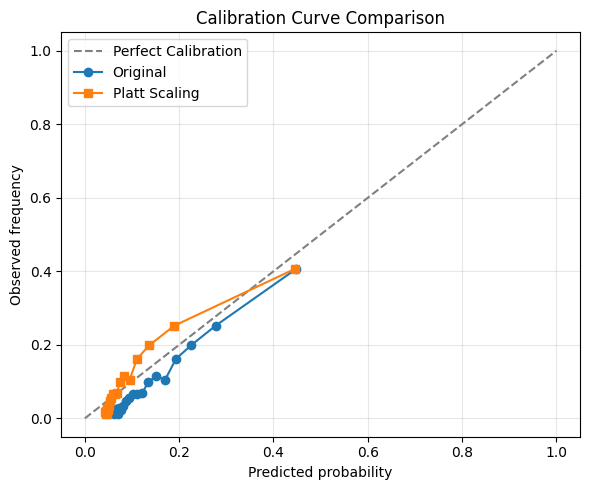

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import joblib

y_prob_raw = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob'].values
y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values

# --- Platt Scaling ---
platt = LogisticRegression(solver='lbfgs')
platt.fit(y_prob_raw.reshape(-1, 1), y_true)
y_prob_platt = platt.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]
joblib.dump(platt, 'calibration_model-AF.pkl')

# # --- Isotonic Scaling (cv=5 → 내부적으로 학습) ---
# iso_clf = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)
# iso_clf.fit(y_prob_raw.reshape(-1, 1), y_true)
# y_prob_iso = iso_clf.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]

# --- Calibration Curves ---
prob_true_raw, prob_pred_raw = calibration_curve(y_true, y_prob_raw, n_bins=20, strategy='quantile')
prob_true_platt, prob_pred_platt = calibration_curve(y_true, y_prob_platt, n_bins=20, strategy='quantile')
# prob_true_iso, prob_pred_iso = calibration_curve(y_true, y_prob_iso, n_bins=20, strategy='quantile')

# --- 시각화 ---
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Original')
plt.plot(prob_pred_platt, prob_true_platt, marker='s', label='Platt Scaling')
# plt.plot(prob_pred_iso, prob_true_iso, marker='^', label='Isotonic Scaling')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'] = y_prob_platt

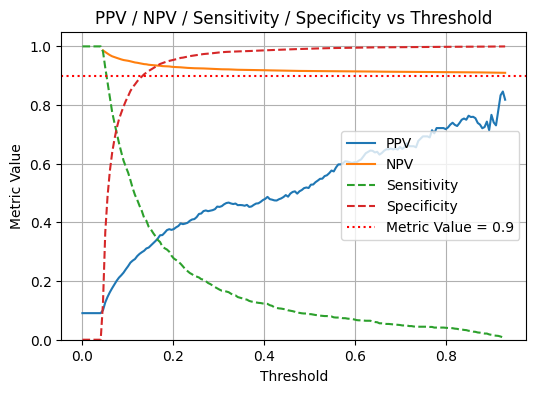

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def compute_metrics_vs_threshold(y_true, y_prob, thresholds=np.linspace(0, 1, 200), min_predicted_positives=10):
    records = []
    for th in thresholds:
        y_pred = (y_prob >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        if (tp + fp) < min_predicted_positives:
            continue  # 해당 threshold는 제외

        ppv = tp / (tp + fp)
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        youden = sensitivity + specificity - 1 if not (np.isnan(sensitivity) or np.isnan(specificity)) else np.nan

        records.append((th, ppv, npv, sensitivity, specificity, youden))

    return pd.DataFrame(records, columns=["threshold", "PPV", "NPV", "Sensitivity", "Specificity", "Youden"])

def plot_metrics_with_vertical_thresholds(df_metrics):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))
    plt.plot(df_metrics["threshold"], df_metrics["PPV"], label="PPV")
    plt.plot(df_metrics["threshold"], df_metrics["NPV"], label="NPV")
    plt.plot(df_metrics["threshold"], df_metrics["Sensitivity"], label="Sensitivity", linestyle='--')
    plt.plot(df_metrics["threshold"], df_metrics["Specificity"], label="Specificity", linestyle='--')

    # y=0.9 위치에 가로 점선 추가
    plt.axhline(0.9, color='r', linestyle=':', label='Metric Value = 0.9')

    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.title("PPV / NPV / Sensitivity / Specificity vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.show()

df_metrics = compute_metrics_vs_threshold(y_true, y_prob_platt.ravel())
plot_metrics_with_vertical_thresholds(df_metrics)

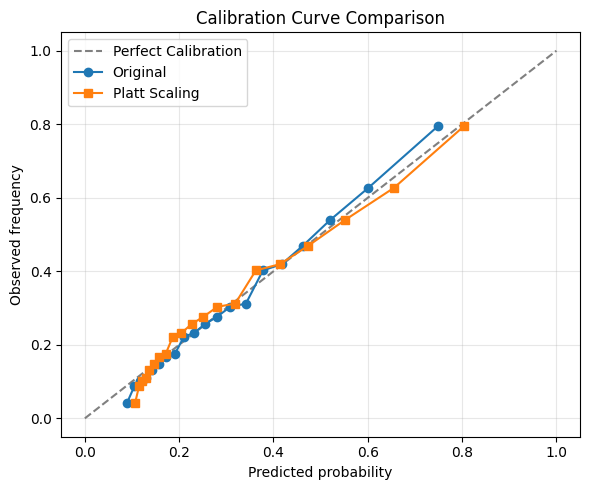

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

y_prob_raw = df['ECG_event_14d_CIA-keyword_v2_onset-prob'].values
y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values

# --- Platt Scaling ---
platt = LogisticRegression(solver='lbfgs')
platt.fit(y_prob_raw.reshape(-1, 1), y_true)
y_prob_platt = platt.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]
joblib.dump(platt, 'calibration_model-CIA.pkl')

# # --- Isotonic Scaling (cv=5 → 내부적으로 학습) ---
# iso_clf = CalibratedClassifierCV(estimator=LogisticRegression(), method='isotonic', cv=5)
# iso_clf.fit(y_prob_raw.reshape(-1, 1), y_true)
# y_prob_iso = iso_clf.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]

# --- Calibration Curves ---
prob_true_raw, prob_pred_raw = calibration_curve(y_true, y_prob_raw, n_bins=20, strategy='quantile')
prob_true_platt, prob_pred_platt = calibration_curve(y_true, y_prob_platt, n_bins=20, strategy='quantile')
# prob_true_iso, prob_pred_iso = calibration_curve(y_true, y_prob_iso, n_bins=20, strategy='quantile')

# --- 시각화 ---
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Original')
plt.plot(prob_pred_platt, prob_true_platt, marker='s', label='Platt Scaling')
# plt.plot(prob_pred_iso, prob_true_iso, marker='^', label='Isotonic Scaling')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'] = y_prob_platt

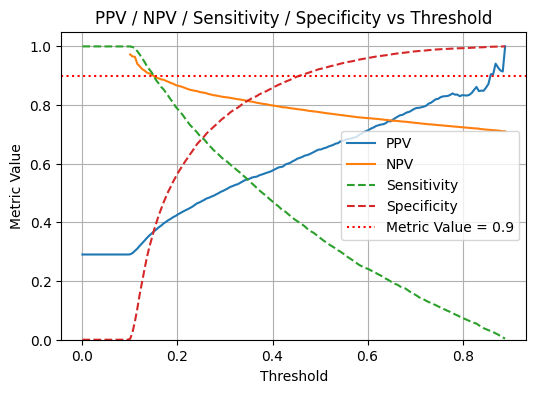

In [273]:
df_metrics = compute_metrics_vs_threshold(y_true, y_prob_platt.ravel())
plot_metrics_with_vertical_thresholds(df_metrics)

In [274]:
df[['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal']].describe()

,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal
count,15190.000000,15190.000000
mean,0.090596,0.290546
std,0.099626,0.192893
min,0.040824,0.096843
25%,0.047772,0.141570
50%,0.057722,0.215084
75%,0.088477,0.387755
max,0.952191,0.902770


In [275]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

def calculate_sens_at_spec(y_true, y_prob, spec_target=0.90):
    """
    특정 특이도(Specificity) 목표치에서의 민감도(Sensitivity)를 계산합니다.
    """
    spec_target_str = str(int(spec_target*100))
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # 목표 FPR (1 - Specificity)
    target_fpr = 1 - spec_target
    
    # 목표 FPR 이하인 모든 인덱스를 찾습니다.
    indices = np.where(fpr <= target_fpr)[0]
    
    if len(indices) > 0:
        # TPR이 가장 높은 지점을 선택합니다.
        best_index = indices[-1]
        sensitivity = tpr[best_index]
        specificity = 1 - fpr[best_index]
        threshold = thresholds[best_index]
        return {f'sens_at_spec{spec_target_str}': sensitivity, 'spec_actual': specificity, 'threshold_spec': threshold}
    else:
        # 조건을 만족하는 지점이 없는 경우
        return {f'sens_at_spec{spec_target_str}': np.nan, 'spec_actual': np.nan, 'threshold_spec': np.nan}

def calculate_ppv_at_npv(y_true, y_prob, npv_target=0.95):
    """
    특정 음성예측도(NPV) 목표치에서의 양성예측도(PPV)를 계산합니다.
    """
    npv_target_str = str(int(npv_target*100))
    thresholds = np.unique(y_prob)

    ppv_list, npv_list = [], []
    
    for th in thresholds:
        y_pred = (y_prob >= th).astype(int)
        # tn, fp, fn, tp = np.bincount(y_true * 2 + y_pred, minlength=4)
        tn, fp, fn, tp = np.bincount(y_true.astype(int) * 2 + y_pred.astype(int), minlength=4)
        
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        
        ppv_list.append(ppv)
        npv_list.append(npv)
        
    results = pd.DataFrame({'threshold': thresholds, 'ppv': ppv_list, 'npv': npv_list})
    
    target_df = results[results['npv'] >= npv_target]
    
    if not target_df.empty:
        # PPV가 가장 높은 지점을 선택합니다.
        best_point = target_df.loc[target_df['ppv'].idxmax()]
        ppv = best_point['ppv']
        npv = best_point['npv']
        threshold = best_point['threshold']
        return {f'ppv_at_npv{npv_target_str}': ppv, 'npv_actual': npv, 'threshold_npv': threshold}
    else:
        # 조건을 만족하는 지점이 없는 경우
        return {f'ppv_at_npv{npv_target_str}': np.nan, 'npv_actual': np.nan, 'threshold_npv': np.nan}


In [276]:
spec_target = 0.90
npv_target  = 0.90


all_results = []

# 각 클래스에 대해 반복하여 성능 지표 계산
for i, class_name in enumerate(['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']):
    print(f"\n===== [ 클래스: {class_name} ] 성능 분석 =====")
    
    # 해당 클래스의 실제값(y_true)과 예측 확률(y_prob) 추출
    true_col = class_name
    prob_col = class_name+'-prob_cal'
    
    y_true = df[true_col].values
    y_prob = df[prob_col].values
    
    # 1. Sens.@Spec90% 계산
    sens_results = calculate_sens_at_spec(y_true, y_prob, spec_target=spec_target)
    spec_target_str = str(int(spec_target*100))
    if not np.isnan(sens_results[f'sens_at_spec{spec_target_str}']):
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 목표 특이도 {spec_target_str}% 하에서 최대 민감도: {sens_results[f'sens_at_spec{spec_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 특이도: {sens_results['spec_actual']:.4f}")
        print(f"  - 최적 임계값: {sens_results['threshold_spec']:.4f}")
    else:
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 특이도 {spec_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 2. PPV@NPV90% 계산
    ppv_results = calculate_ppv_at_npv(y_true, y_prob, npv_target=npv_target)
    npv_target_str = str(int(npv_target*100))
    if not np.isnan(ppv_results[f'ppv_at_npv{npv_target_str}']):
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - 목표 NPV {npv_target_str}% 하에서 최대 PPV: {ppv_results[f'ppv_at_npv{npv_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 NPV: {ppv_results['npv_actual']:.4f}")
        print(f"  - 최적 임계값: {ppv_results['threshold_npv']:.4f}")
    else:
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - NPV {npv_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 평균 계산을 위해 결과 저장
    class_summary = {'class': class_name, **sens_results, **ppv_results}
    all_results.append(class_summary)

# --- 최종 평균 결과 출력 ---

# DataFrame으로 변환하여 평균 계산
results_df = pd.DataFrame(all_results).set_index('class')
average_results = results_df.mean()

print("\n\n=============================================")
print("=====         전체 클래스 평균         =====")
print("=============================================")
print(f"\n[평균 Sens.@Spec{spec_target_str}%]")
print(f"  - 평균 민감도: {average_results.get(f'sens_at_spec{spec_target_str}', np.nan):.4f}")
print(f"\n[평균 PPV@NPV{npv_target_str}%]")
print(f"  - 평균 PPV: {average_results.get(f'ppv_at_npv{npv_target_str}', np.nan):.4f}")
print("\n--- (참고) 개별 클래스 상세 결과 ---")
print(results_df.round(4))


===== [ 클래스: ECG_event_14d_AFIB_AFL-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.4295
  - 해당 지점 실제 특이도: 0.9001
  - 최적 임계값: 0.1322

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 1.0000
  - 해당 지점 실제 NPV: 0.9098
  - 최적 임계값: 0.9396

===== [ 클래스: ECG_event_14d_CIA-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3981
  - 해당 지점 실제 특이도: 0.9002
  - 최적 임계값: 0.4573

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.3659
  - 해당 지점 실제 NPV: 0.9004
  - 최적 임계값: 0.1481


=====         전체 클래스 평균         =====

[평균 Sens.@Spec90%]
  - 평균 민감도: 0.4138

[평균 PPV@NPV90%]
  - 평균 PPV: 0.6829

--- (참고) 개별 클래스 상세 결과 ---
                                         sens_at_spec90  spec_actual  \
class                                                                  
ECG_event_14d_AFIB_AFL-keyword_v2_onset          0.4295       0.9001   
ECG_event_14d_CIA-keyword_v2_onset               0.3981       0.9002   

                                         threshold_spec  ppv_at_

In [277]:
import numpy as np
import pandas as pd

# tmp_df = df.copy()

y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['AF-risk'] = risk_group

y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['CIA-risk'] = risk_group


In [278]:
import numpy as np
import pandas as pd
from processing import utils

# AF-risk, CIA-risk 컬럼을 활용하여 그룹별 평가지표 + 유병율(prev) 산출
for class_name, risk_col, label_col, prob_col in [
    ('AF', 'AF-risk', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'),
    ('CIA', 'CIA-risk', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal')
]:
    print(f"\n===== {class_name} Risk Group별 평가지표 =====")
    y_true = df[label_col].values
    y_prob = df[prob_col].values
    risk_group = df[risk_col].values

    results = {}
    prevs = {}
    for group in ['high', 'intermediate', 'low']:
        mask = (risk_group == group)
        y_true_g = y_true[mask].reshape(-1, 1)
        y_prob_g = y_prob[mask].reshape(-1, 1)
        results[group] = utils.classification_metrics(
            y = y_true_g,
            y_pred = y_prob_g,
            activation_fn=False,
            threshold_method='youden'
        )
        # 유병율(%) 계산
        prevs[group] = 100 * y_true_g.mean() if len(y_true_g) > 0 else np.nan

    # 결과를 DataFrame으로 정리
    df_list = []
    for group, res in results.items():
        tmp_df = pd.DataFrame(res).T
        tmp_df['risk_group'] = group
        tmp_df['class'] = class_name
        tmp_df['prev(%)'] = prevs[group]
        df_list.append(tmp_df.drop('avg'))
    metrics_df = pd.concat(df_list, axis=0).reset_index(drop=True)
    display(metrics_df.round(4))



===== AF Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.6345,0.4836,0.2697,0.6230,0.5580,0.4422,0.6549,0.7514,0.4934,668.0,352.0,221.0,279.0,1520.0,high,AF,32.8947
1,0.5855,0.1825,0.1048,0.5737,0.5841,0.1877,0.5720,0.8904,0.2841,1486.0,1112.0,183.0,257.0,3038.0,intermediate,AF,14.4832
2,0.6768,0.0796,0.0523,0.5851,0.7110,0.0675,0.5797,0.9791,0.1232,5911.0,4285.0,126.0,310.0,10632.0,low,AF,4.1008



===== CIA Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.6417,0.8114,0.7444,0.5559,0.4806,0.8199,0.7409,0.3675,0.6060,326.0,114.0,561.0,519.0,1520.0,high,CIA,71.0526
1,0.5603,0.5052,0.4642,0.5610,0.4669,0.5217,0.6400,0.5881,0.4928,1058.0,595.0,741.0,649.0,3043.0,intermediate,CIA,45.6786
2,0.6593,0.2731,0.1722,0.6019,0.6634,0.2649,0.5881,0.8865,0.3786,5107.0,3577.0,654.0,1289.0,10627.0,low,CIA,18.2836


In [279]:
def calculate_odds_ratio_from_prevalence(prevalence_a, prevalence_b):
    """
    유병률을 사용하여 오즈비를 계산합니다.
    Args:
        prevalence_a (float): A 그룹의 유병률 (0과 1 사이의 값)
        prevalence_b (float): B 그룹의 유병률 (0과 1 사이의 값)
    Returns:
        float: 오즈비
    """
    if prevalence_a >= 1 or prevalence_b >= 1:
        raise ValueError("유병률은 1보다 작아야 합니다.")
    if prevalence_a < 0 or prevalence_b < 0:
        raise ValueError("유병률은 0보다 커야 합니다.")

    # 각 그룹의 오즈(Odds) 계산
    odds_a = prevalence_a / (1 - prevalence_a)
    odds_b = prevalence_b / (1 - prevalence_b)

    # 오즈비 계산
    if odds_b == 0:
        return float('inf') # 무한대 반환
    else:
        odds_ratio = odds_a / odds_b
        return odds_ratio

# 예시: A 그룹 유병률 30%, B 그룹 유병률 10%
prevalence_a = 0.71
prevalence_b = 0.45

or_value = calculate_odds_ratio_from_prevalence(prevalence_a, prevalence_b)
print(f"오즈비: {or_value:.4f}")

# 결과: 오즈비: 3.8571

오즈비: 2.9923



===== AF Risk Group @ high =====


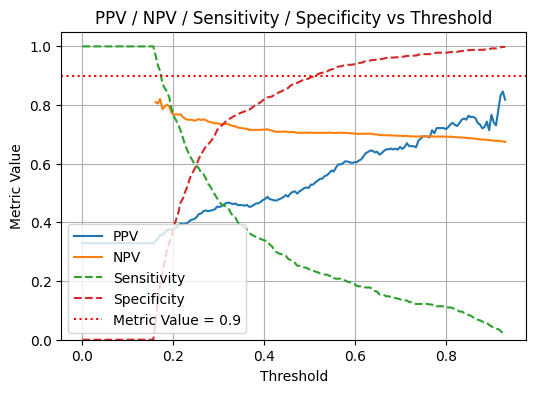


===== AF Risk Group @ intermediate =====


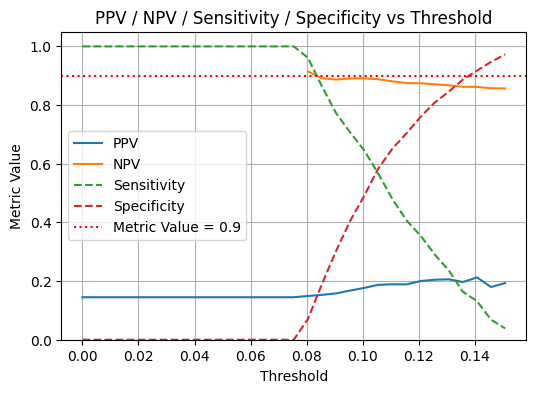


===== AF Risk Group @ low =====


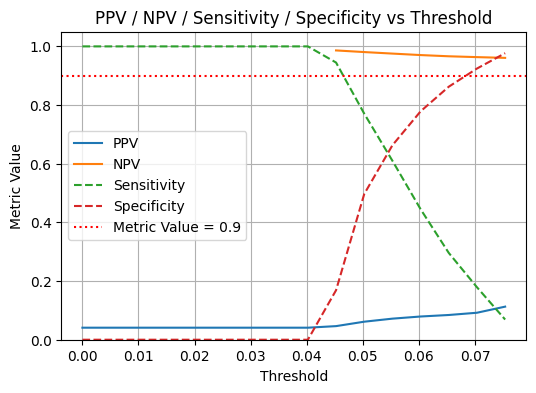


===== CIA Risk Group @ high =====


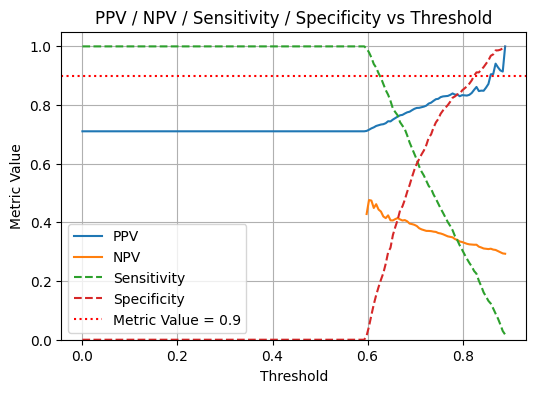


===== CIA Risk Group @ intermediate =====


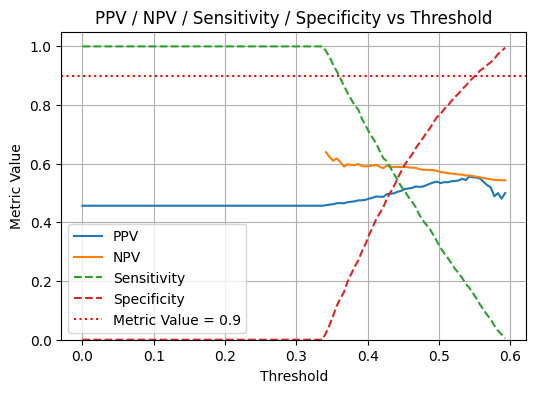


===== CIA Risk Group @ low =====


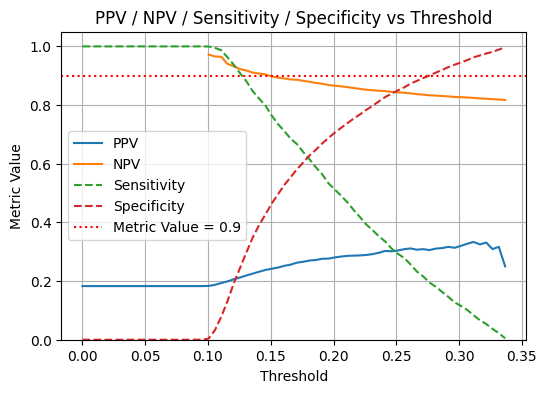

In [280]:
for class_name, risk_col, label_col, prob_col in [
    ('AF', 'AF-risk', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'),
    ('CIA', 'CIA-risk', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal')
]:
    y_true = df[label_col].values
    y_prob = df[prob_col].values
    risk_group = df[risk_col].values

    results = {}
    for group in ['high', 'intermediate', 'low']:
        print(f"\n===== {class_name} Risk Group @ {group} =====")
        mask = (risk_group == group)
        y_true_g = y_true[mask].reshape(-1, 1)
        y_prob_g = y_prob[mask].reshape(-1, 1)

        df_metrics = compute_metrics_vs_threshold(y_true_g, y_prob_g.ravel())
        plot_metrics_with_vertical_thresholds(df_metrics)

        # break
    # break

In [281]:
df.to_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv', index=False)

## 서브셋 분석

In [282]:
import pandas as pd

target_cols = ['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']
df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')
df

/tmp/ipykernel_4182979/3001796930.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')


,path,error,pid,name,age,sex,date,time,rate,hr,...,ECG_event_30d_AFIB_AFL-keyword_v2_onset-prob,ECG_event_30d_CIA-keyword_v2_onset-prob,ECG_event_90d_AFIB_AFL-keyword_v2_onset-prob,ECG_event_90d_CIA-keyword_v2_onset-prob,AFIB_AFL-keyword_v2-prob,CIA-keyword_v2-prob,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal,AF-risk,CIA-risk
0,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10302870.0,NaN,68,Male,2023-10-17,15:52:13,500.0,57.0,...,0.10450,0.2770,0.10864,0.2837,0.04916,0.07263,0.057403,0.236969,low,low
1,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10203160.0,NaN,77,Unknown,2023-10-04,11:31:40,500.0,67.0,...,0.17220,0.3645,0.18020,0.3857,0.05325,0.06903,0.088778,0.337951,intermediate,low
2,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10144268.0,NaN,83,Female,2024-06-02,14:05:06,500.0,84.0,...,0.07150,0.1329,0.07336,0.1434,0.05030,0.05045,0.047434,0.128781,low,low
3,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10298910.0,NaN,58,Unknown,2024-05-08,14:32:17,500.0,50.0,...,0.50050,0.7715,0.52100,0.7856,0.22460,0.70750,0.511614,0.827393,high,high
4,/mnt/home/Datasets/EKG_RAW/EKG_Data3_202307_20...,Clear,10591606.0,NaN,84,Male,2024-07-13,14:22:36,500.0,100.0,...,0.06800,0.1364,0.06964,0.1484,0.05408,0.07280,0.046124,0.130125,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15185,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,10377643.0,NaN,55,Unknown,2023-03-11,07:57:01,500.0,90.0,...,0.09015,0.1859,0.09230,0.1976,0.05142,0.05225,0.052963,0.163832,low,low
15186,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,94464399.0,park jy,66,Male,2023-02-20,12:44:44,500.0,0.0,...,0.20350,0.3604,0.20800,0.3830,0.05124,0.05347,0.110165,0.332036,intermediate,low
15187,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,16128787.0,NaN,83,Female,2022-12-12,17:33:19,500.0,54.0,...,0.07620,0.3948,0.08440,0.4114,0.04578,0.48460,0.048625,0.381086,low,intermediate
15188,/mnt/home/Datasets/EKG_RAW/ECG_Data_20221101_2...,Clear,10577459.0,NaN,82,Unknown,2022-12-24,08:21:17,500.0,114.0,...,0.14930,0.4363,0.15950,0.4521,0.04837,0.09920,0.076239,0.436418,low,intermediate


In [110]:
# AF와 CIA에 대한 라벨/확률 컬럼명 리스트
label_cols = target_cols
prob_cols = [label + '-prob_cal' for label in label_cols]

# pid_str 기준으로 모든 라벨/확률을 집계
agg_dict = {col: 'max' for col in label_cols + prob_cols}
agg_dict.update({'sex_f0_m1': 'first', 'age_float': 'first'})

pid_df = df.groupby('pid_str').agg(agg_dict).reset_index()

# 결과 확인
display(pid_df)

,pid_str,ECG_event_14d_AFIB_AFL-keyword_v2_onset,ECG_event_14d_CIA-keyword_v2_onset,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal,sex_f0_m1,age_float
0,p10000007,0,1,0.098429,0.340745,0.0,77.0
1,p10000171,1,1,0.205476,0.554264,1.0,57.0
2,p10001112,0,1,0.049342,0.317539,NaN,50.0
3,p10001658,0,1,0.077986,0.306374,0.0,86.0
4,p10001744,0,0,0.056822,0.193264,1.0,79.0
...,...,...,...,...,...,...,...
5937,p97091271,0,0,0.093460,0.580198,0.0,50.0
5938,p97098311,0,0,0.046304,0.127329,0.0,50.0
5939,p97101750,0,0,0.060224,0.218859,1.0,78.0
5940,p97101969,1,1,0.064576,0.230948,0.0,50.0


### 노 기한

In [47]:
# ...existing code...
from processing import utils

results = []
for target_col in target_cols:  # 원하는 클래스 인덱스 리스트
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    # 1. pid_str 기준으로 집계 (예: 최대값)
    pid_df = df.groupby('pid_str').agg({
        label_col: 'max',      # 실제값: 한 번이라도 이벤트 있으면 1
        prob_col: 'max',       # 예측값: 최대 확률
        'sex_f0_m1': 'first',  # 성별
        'age_float': 'first'   # 나이
    }).reset_index()

    # 2. 환자 기준 평가지표 산출
    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))
# ...existing code...

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class
0,0.8408,0.4053,0.2217,0.9084,0.4447,0.4248,0.9483,0.9521,0.4345,5189.0,283.0,261.0,209.0,5942.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset
1,0.8079,0.6326,0.3403,0.7807,0.6397,0.5622,0.8291,0.8702,0.5985,3668.0,756.0,547.0,971.0,5942.0,ECG_event_14d_CIA-keyword_v2_onset


### 3개월ㅡ

In [50]:
import pandas as pd
from processing import utils

# 'ecg_record_date' 컬럼을 datetime 형식으로 변환 (필수)
df['ecg_record_date'] = pd.to_datetime(df['ecg_record_date'])
df = df.sort_values(by=['pid_str', 'ecg_record_date']).reset_index(drop=True)

# 환자별로 날짜를 인덱스로 설정
df_time_indexed = df.set_index('ecg_record_date')

af_label_col = target_cols[0]
af_prob_col = af_label_col + '-prob_cal'
cia_label_col = target_cols[1]
cia_prob_col = cia_label_col + '-prob_cal'

# 가중 평균 계산 함수 (Series를 받음)
def weighted_avg(series):
    if len(series) == 1:
        return series.iloc[0]
    
    last_val = series.iloc[-1]
    other_vals = series.iloc[:-1]
    
    if other_vals.empty:
        return last_val
        
    return (last_val * 0.5) + (other_vals.mean() * 0.5)

# 1. AF 라벨과 확률 집계 (각각 독립적으로)
af_label_series = df_time_indexed.groupby('pid_str')[af_label_col].rolling('90d', closed='left').max()
af_prob_series = df_time_indexed.groupby('pid_str')[af_prob_col].rolling('90d', closed='left').apply(weighted_avg, raw=False)

# 2. CIA 라벨과 확률 집계 (각각 독립적으로)
cia_label_series = df_time_indexed.groupby('pid_str')[cia_label_col].rolling('90d', closed='left').max()
cia_prob_series = df_time_indexed.groupby('pid_str')[cia_prob_col].rolling('90d', closed='left').apply(weighted_avg, raw=False)

# 3. 모든 결과를 하나의 DataFrame으로 합치기
pid_df = pd.DataFrame({
    'pid_str': af_label_series.index.get_level_values('pid_str'),
    'ecg_record_date': af_label_series.index.get_level_values('ecg_record_date'),
    af_label_col: af_label_series.values,
    af_prob_col: af_prob_series.values,
    cia_label_col: cia_label_series.values,
    cia_prob_col: cia_prob_series.values
})

# 4. 기타 환자 정보(성별, 나이) 병합
patient_info_df = df.drop_duplicates('pid_str')[['pid_str', 'sex_f0_m1', 'age_float']]
pid_df = pd.merge(pid_df, patient_info_df, on='pid_str')
    
# 5. 결측치 및 중복 제거
pid_df.dropna(subset=[af_label_col, af_prob_col, cia_label_col, cia_prob_col], inplace=True)
pid_df = pid_df.drop_duplicates(subset=['pid_str', 'ecg_record_date'], keep='last').reset_index(drop=True)

# 6. 환자 기준 평가지표 산출 (개별 클래스에 대해 루프 실행)
results = []
for target_col in [af_label_col, cia_label_col]:
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class
0,0.7700,0.4026,0.1025,0.7734,0.6000,0.3835,0.8079,0.9102,0.4679,5942.0,1413.0,586.0,879.0,8820.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset
1,0.7599,0.7256,0.2139,0.6795,0.8037,0.6201,0.5714,0.7697,0.7001,2694.0,2021.0,806.0,3299.0,8820.0,ECG_event_14d_CIA-keyword_v2_onset


In [54]:
df = pid_df.copy()
df

,pid_str,ecg_record_date,ECG_event_14d_AFIB_AFL-keyword_v2_onset,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset,ECG_event_14d_CIA-keyword_v2_onset-prob_cal,sex_f0_m1,age_float
0,p10000007,2024-04-22 20:33:57,0.0,0.098429,1.0,0.316366,0.0,77.0
1,p10000007,2024-04-22 23:08:51,0.0,0.096515,1.0,0.328555,0.0,77.0
2,p10000007,2024-04-23 14:29:41,0.0,0.076135,1.0,0.244391,0.0,77.0
3,p10000171,2022-05-28 05:57:04,1.0,0.073356,1.0,0.362609,1.0,57.0
4,p10000171,2022-05-28 10:12:43,1.0,0.076755,1.0,0.342669,1.0,57.0
...,...,...,...,...,...,...,...,...
8815,p97101969,2022-05-15 11:54:12,1.0,0.060395,1.0,0.195013,0.0,47.0
8816,p97101969,2022-05-17 07:23:26,1.0,0.056644,1.0,0.174463,0.0,47.0
8817,p97101969,2022-05-17 16:26:57,1.0,0.058998,1.0,0.204709,0.0,47.0
8818,p97121002,2023-03-24 09:46:49,0.0,0.078040,0.0,0.239724,0.0,59.0


In [56]:
spec_target = 0.90
npv_target  = 0.90


all_results = []

# 각 클래스에 대해 반복하여 성능 지표 계산
for i, class_name in enumerate(['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']):
    print(f"\n===== [ 클래스: {class_name} ] 성능 분석 =====")
    
    # 해당 클래스의 실제값(y_true)과 예측 확률(y_prob) 추출
    true_col = class_name
    prob_col = class_name+'-prob_cal'
    
    y_true = df[true_col].values
    y_prob = df[prob_col].values
    
    # 1. Sens.@Spec90% 계산
    sens_results = calculate_sens_at_spec(y_true, y_prob, spec_target=spec_target)
    spec_target_str = str(int(spec_target*100))
    if not np.isnan(sens_results[f'sens_at_spec{spec_target_str}']):
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 목표 특이도 {spec_target_str}% 하에서 최대 민감도: {sens_results[f'sens_at_spec{spec_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 특이도: {sens_results['spec_actual']:.4f}")
        print(f"  - 최적 임계값: {sens_results['threshold_spec']:.4f}")
    else:
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 특이도 {spec_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 2. PPV@NPV90% 계산
    ppv_results = calculate_ppv_at_npv(y_true, y_prob, npv_target=npv_target)
    npv_target_str = str(int(npv_target*100))
    if not np.isnan(ppv_results[f'ppv_at_npv{npv_target_str}']):
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - 목표 NPV {npv_target_str}% 하에서 최대 PPV: {ppv_results[f'ppv_at_npv{npv_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 NPV: {ppv_results['npv_actual']:.4f}")
        print(f"  - 최적 임계값: {ppv_results['threshold_npv']:.4f}")
    else:
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - NPV {npv_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 평균 계산을 위해 결과 저장
    class_summary = {'class': class_name, **sens_results, **ppv_results}
    all_results.append(class_summary)

# --- 최종 평균 결과 출력 ---

# DataFrame으로 변환하여 평균 계산
results_df = pd.DataFrame(all_results).set_index('class')
average_results = results_df.mean()

print("\n\n=============================================")
print("=====         전체 클래스 평균         =====")
print("=============================================")
print(f"\n[평균 Sens.@Spec{spec_target_str}%]")
print(f"  - 평균 민감도: {average_results.get(f'sens_at_spec{spec_target_str}', np.nan):.4f}")
print(f"\n[평균 PPV@NPV{npv_target_str}%]")
print(f"  - 평균 PPV: {average_results.get(f'ppv_at_npv{npv_target_str}', np.nan):.4f}")
print("\n--- (참고) 개별 클래스 상세 결과 ---")
print(results_df.round(4))


===== [ 클래스: ECG_event_14d_AFIB_AFL-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3986
  - 해당 지점 실제 특이도: 0.9002
  - 최적 임계값: 0.1449

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.4018
  - 해당 지점 실제 NPV: 0.9003
  - 최적 임계값: 0.1155

===== [ 클래스: ECG_event_14d_CIA-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3881
  - 해당 지점 실제 특이도: 0.9003
  - 최적 임계값: 0.4485

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.4766
  - 해당 지점 실제 NPV: 0.9070
  - 최적 임계값: 0.1123


=====         전체 클래스 평균         =====

[평균 Sens.@Spec90%]
  - 평균 민감도: 0.3933

[평균 PPV@NPV90%]
  - 평균 PPV: 0.4392

--- (참고) 개별 클래스 상세 결과 ---
                                         sens_at_spec90  spec_actual  \
class                                                                  
ECG_event_14d_AFIB_AFL-keyword_v2_onset          0.3986       0.9002   
ECG_event_14d_CIA-keyword_v2_onset               0.3881       0.9003   

                                         threshold_spec  ppv_at_

In [57]:
import numpy as np
import pandas as pd

# tmp_df = df.copy()

y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['AF-risk'] = risk_group

y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['CIA-risk'] = risk_group


In [58]:
import numpy as np
import pandas as pd
from processing import utils

# AF-risk, CIA-risk 컬럼을 활용하여 그룹별 평가지표 + 유병율(prev) 산출
for class_name, risk_col, label_col, prob_col in [
    ('AF', 'AF-risk', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'),
    ('CIA', 'CIA-risk', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal')
]:
    print(f"\n===== {class_name} Risk Group별 평가지표 =====")
    y_true = df[label_col].values
    y_prob = df[prob_col].values
    risk_group = df[risk_col].values

    results = {}
    prevs = {}
    for group in ['high', 'intermediate', 'low']:
        mask = (risk_group == group)
        y_true_g = y_true[mask].reshape(-1, 1)
        y_prob_g = y_prob[mask].reshape(-1, 1)
        results[group] = utils.classification_metrics(
            y = y_true_g,
            y_pred = y_prob_g,
            activation_fn=False,
            threshold_method='youden'
        )
        # 유병율(%) 계산
        prevs[group] = 100 * y_true_g.mean() if len(y_true_g) > 0 else np.nan

    # 결과를 DataFrame으로 정리
    df_list = []
    for group, res in results.items():
        tmp_df = pd.DataFrame(res).T
        tmp_df['risk_group'] = group
        tmp_df['class'] = class_name
        tmp_df['prev(%)'] = prevs[group]
        df_list.append(tmp_df.drop('avg'))
    metrics_df = pd.concat(df_list, axis=0).reset_index(drop=True)
    display(metrics_df.round(4))



===== AF Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.5571,0.5445,0.2736,0.5635,0.5164,0.5539,0.6079,0.5714,0.5345,276.0,178.0,207.0,221.0,882.0,high,AF,48.5261
1,0.5865,0.3500,0.1163,0.5142,0.6791,0.3337,0.4469,0.7735,0.4475,560.0,693.0,164.0,347.0,1764.0,intermediate,AF,28.9683
2,0.6642,0.1398,0.0550,0.5384,0.7490,0.1266,0.5188,0.9569,0.2166,2930.0,2718.0,132.0,394.0,6174.0,low,AF,8.5196



===== CIA Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.6061,0.8830,0.6581,0.6689,0.7022,0.8801,0.4929,0.2379,0.7811,69.0,71.0,221.0,521.0,882.0,high,CIA,84.1270
1,0.5496,0.7278,0.4584,0.5913,0.6577,0.7283,0.4395,0.3598,0.6912,236.0,301.0,420.0,807.0,1764.0,intermediate,CIA,69.5578
2,0.6879,0.5096,0.2139,0.6518,0.6227,0.4974,0.6672,0.7697,0.5530,2694.0,1344.0,806.0,1330.0,6174.0,low,CIA,34.5967


### 2주

In [63]:
import pandas as pd

target_cols = ['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']
df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')

/tmp/ipykernel_4182979/3612870208.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')


In [64]:
import pandas as pd
from processing import utils

# 'ecg_record_date' 컬럼을 datetime 형식으로 변환 (필수)
df['ecg_record_date'] = pd.to_datetime(df['ecg_record_date'])
df = df.sort_values(by=['pid_str', 'ecg_record_date']).reset_index(drop=True)

# 환자별로 날짜를 인덱스로 설정
df_time_indexed = df.set_index('ecg_record_date')

af_label_col = target_cols[0]
af_prob_col = af_label_col + '-prob_cal'
cia_label_col = target_cols[1]
cia_prob_col = cia_label_col + '-prob_cal'

# 가중 평균 계산 함수 (Series를 받음)
def weighted_avg(series):
    if len(series) == 1:
        return series.iloc[0]
    
    last_val = series.iloc[-1]
    other_vals = series.iloc[:-1]
    
    if other_vals.empty:
        return last_val
        
    return (last_val * 0.5) + (other_vals.mean() * 0.5)

# 1. AF 라벨과 확률 집계 (각각 독립적으로)
af_label_series = df_time_indexed.groupby('pid_str')[af_label_col].rolling('14d', closed='left').max()
af_prob_series = df_time_indexed.groupby('pid_str')[af_prob_col].rolling('14d', closed='left').apply(weighted_avg, raw=False)

# 2. CIA 라벨과 확률 집계 (각각 독립적으로)
cia_label_series = df_time_indexed.groupby('pid_str')[cia_label_col].rolling('14d', closed='left').max()
cia_prob_series = df_time_indexed.groupby('pid_str')[cia_prob_col].rolling('14d', closed='left').apply(weighted_avg, raw=False)

# 3. 모든 결과를 하나의 DataFrame으로 합치기
pid_df = pd.DataFrame({
    'pid_str': af_label_series.index.get_level_values('pid_str'),
    'ecg_record_date': af_label_series.index.get_level_values('ecg_record_date'),
    af_label_col: af_label_series.values,
    af_prob_col: af_prob_series.values,
    cia_label_col: cia_label_series.values,
    cia_prob_col: cia_prob_series.values
})

# 4. 기타 환자 정보(성별, 나이) 병합
patient_info_df = df.drop_duplicates('pid_str')[['pid_str', 'sex_f0_m1', 'age_float']]
pid_df = pd.merge(pid_df, patient_info_df, on='pid_str')
    
# 5. 결측치 및 중복 제거
pid_df.dropna(subset=[af_label_col, af_prob_col, cia_label_col, cia_prob_col], inplace=True)
pid_df = pid_df.drop_duplicates(subset=['pid_str', 'ecg_record_date'], keep='last').reset_index(drop=True)

# 6. 환자 기준 평가지표 산출 (개별 클래스에 대해 루프 실행)
results = []
for target_col in [af_label_col, cia_label_col]:
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class
0,0.7719,0.3955,0.1025,0.7766,0.6054,0.3740,0.8089,0.9158,0.4623,5696.0,1346.0,524.0,804.0,8370.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset
1,0.7548,0.7095,0.2139,0.6714,0.8038,0.6027,0.5621,0.7761,0.6888,2576.0,2007.0,743.0,3044.0,8370.0,ECG_event_14d_CIA-keyword_v2_onset


In [65]:
df = pid_df.copy()

In [66]:
spec_target = 0.90
npv_target  = 0.90


all_results = []

# 각 클래스에 대해 반복하여 성능 지표 계산
for i, class_name in enumerate(['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']):
    print(f"\n===== [ 클래스: {class_name} ] 성능 분석 =====")
    
    # 해당 클래스의 실제값(y_true)과 예측 확률(y_prob) 추출
    true_col = class_name
    prob_col = class_name+'-prob_cal'
    
    y_true = df[true_col].values
    y_prob = df[prob_col].values
    
    # 1. Sens.@Spec90% 계산
    sens_results = calculate_sens_at_spec(y_true, y_prob, spec_target=spec_target)
    spec_target_str = str(int(spec_target*100))
    if not np.isnan(sens_results[f'sens_at_spec{spec_target_str}']):
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 목표 특이도 {spec_target_str}% 하에서 최대 민감도: {sens_results[f'sens_at_spec{spec_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 특이도: {sens_results['spec_actual']:.4f}")
        print(f"  - 최적 임계값: {sens_results['threshold_spec']:.4f}")
    else:
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 특이도 {spec_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 2. PPV@NPV90% 계산
    ppv_results = calculate_ppv_at_npv(y_true, y_prob, npv_target=npv_target)
    npv_target_str = str(int(npv_target*100))
    if not np.isnan(ppv_results[f'ppv_at_npv{npv_target_str}']):
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - 목표 NPV {npv_target_str}% 하에서 최대 PPV: {ppv_results[f'ppv_at_npv{npv_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 NPV: {ppv_results['npv_actual']:.4f}")
        print(f"  - 최적 임계값: {ppv_results['threshold_npv']:.4f}")
    else:
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - NPV {npv_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 평균 계산을 위해 결과 저장
    class_summary = {'class': class_name, **sens_results, **ppv_results}
    all_results.append(class_summary)

# --- 최종 평균 결과 출력 ---

# DataFrame으로 변환하여 평균 계산
results_df = pd.DataFrame(all_results).set_index('class')
average_results = results_df.mean()

print("\n\n=============================================")
print("=====         전체 클래스 평균         =====")
print("=============================================")
print(f"\n[평균 Sens.@Spec{spec_target_str}%]")
print(f"  - 평균 민감도: {average_results.get(f'sens_at_spec{spec_target_str}', np.nan):.4f}")
print(f"\n[평균 PPV@NPV{npv_target_str}%]")
print(f"  - 평균 PPV: {average_results.get(f'ppv_at_npv{npv_target_str}', np.nan):.4f}")
print("\n--- (참고) 개별 클래스 상세 결과 ---")
print(results_df.round(4))


===== [ 클래스: ECG_event_14d_AFIB_AFL-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.4029
  - 해당 지점 실제 특이도: 0.9002
  - 최적 임계값: 0.1460

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.3978
  - 해당 지점 실제 NPV: 0.9002
  - 최적 임계값: 0.1230

===== [ 클래스: ECG_event_14d_CIA-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3821
  - 해당 지점 실제 특이도: 0.9001
  - 최적 임계값: 0.4592

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.4624
  - 해당 지점 실제 NPV: 0.9031
  - 최적 임계값: 0.1123


=====         전체 클래스 평균         =====

[평균 Sens.@Spec90%]
  - 평균 민감도: 0.3925

[평균 PPV@NPV90%]
  - 평균 PPV: 0.4301

--- (참고) 개별 클래스 상세 결과 ---
                                         sens_at_spec90  spec_actual  \
class                                                                  
ECG_event_14d_AFIB_AFL-keyword_v2_onset          0.4029       0.9002   
ECG_event_14d_CIA-keyword_v2_onset               0.3821       0.9001   

                                         threshold_spec  ppv_at_

In [67]:
import numpy as np
import pandas as pd

# tmp_df = df.copy()

y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['AF-risk'] = risk_group

y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['CIA-risk'] = risk_group


In [68]:
import numpy as np
import pandas as pd
from processing import utils

# AF-risk, CIA-risk 컬럼을 활용하여 그룹별 평가지표 + 유병율(prev) 산출
for class_name, risk_col, label_col, prob_col in [
    ('AF', 'AF-risk', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'),
    ('CIA', 'CIA-risk', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal')
]:
    print(f"\n===== {class_name} Risk Group별 평가지표 =====")
    y_true = df[label_col].values
    y_prob = df[prob_col].values
    risk_group = df[risk_col].values

    results = {}
    prevs = {}
    for group in ['high', 'intermediate', 'low']:
        mask = (risk_group == group)
        y_true_g = y_true[mask].reshape(-1, 1)
        y_prob_g = y_prob[mask].reshape(-1, 1)
        results[group] = utils.classification_metrics(
            y = y_true_g,
            y_pred = y_prob_g,
            activation_fn=False,
            threshold_method='youden'
        )
        # 유병율(%) 계산
        prevs[group] = 100 * y_true_g.mean() if len(y_true_g) > 0 else np.nan

    # 결과를 DataFrame으로 정리
    df_list = []
    for group, res in results.items():
        tmp_df = pd.DataFrame(res).T
        tmp_df['risk_group'] = group
        tmp_df['class'] = class_name
        tmp_df['prev(%)'] = prevs[group]
        df_list.append(tmp_df.drop('avg'))
    metrics_df = pd.concat(df_list, axis=0).reset_index(drop=True)
    display(metrics_df.round(4))



===== AF Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.5580,0.5404,0.3416,0.5699,0.3559,0.5796,0.7648,0.5659,0.4410,335.0,103.0,257.0,142.0,837.0,high,AF,47.6703
1,0.5813,0.3313,0.1025,0.4235,0.8766,0.3085,0.2508,0.8421,0.4563,304.0,908.0,57.0,405.0,1674.0,intermediate,AF,27.5986
2,0.6629,0.1322,0.0550,0.5383,0.7473,0.1189,0.5202,0.9596,0.2051,2805.0,2587.0,118.0,349.0,5859.0,low,AF,7.9706



===== CIA Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.5976,0.8685,0.7271,0.4570,0.3919,0.8824,0.7584,0.2124,0.5427,113.0,36.0,419.0,270.0,838.0,high,CIA,82.2196
1,0.5515,0.7122,0.4638,0.5828,0.6479,0.7118,0.4451,0.3740,0.6783,239.0,298.0,400.0,736.0,1673.0,intermediate,CIA,67.9020
2,0.6827,0.4936,0.2139,0.6477,0.6213,0.4799,0.6610,0.7761,0.5415,2576.0,1321.0,743.0,1219.0,5859.0,low,CIA,33.4869


### 2주 버전2

In [304]:
import pandas as pd

target_cols = ['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']
df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')

/tmp/ipykernel_4182979/3612870208.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/mnt/home/bgk/macai-engine-v1/notebooks/calibration/assets/TRN-MacAI_v1_2-0822_tmp-eumc_results.csv')


In [305]:
import pandas as pd
from processing import utils

# 'ecg_record_date' 컬럼을 datetime 형식으로 변환 (필수)
df['ecg_record_date'] = pd.to_datetime(df['ecg_record_date'])
df = df.sort_values(by=['pid_str', 'ecg_record_date']).reset_index(drop=True)

# 환자별로 날짜를 인덱스로 설정
df_time_indexed = df.set_index('ecg_record_date')

af_label_col = target_cols[0]
af_prob_col = af_label_col + '-prob_cal'
# af_prob_col = af_label_col + '-prob'
cia_label_col = target_cols[1]
cia_prob_col = cia_label_col + '-prob_cal'
# cia_prob_col = cia_label_col + '-prob'

# 가중 평균 계산 함수 (Series를 받음)
def weighted_avg(series):
    if len(series) == 1:
        return series.iloc[0]
    last_val = series.iloc[-1]
    other_vals = series.iloc[:-1]
    if other_vals.empty:
        return last_val        
    return (last_val * 0.5) + (other_vals.mean() * 0.5)

# 가중 평균이 아닌, 단순 평균을 계산하는 함수
def simple_avg(series):
    # 윈도우 내의 모든 값의 평균을 반환합니다.
    return series.mean()

# 1. AF 라벨과 확률 집계 (각각 독립적으로)
af_label_series = df_time_indexed.groupby('pid_str')[af_label_col].rolling('14d', closed='left').max()
af_prob_series = df_time_indexed.groupby('pid_str')[af_prob_col].rolling('14d', closed='left').apply(simple_avg, raw=False)

# 2. CIA 라벨과 확률 집계 (각각 독립적으로)
cia_label_series = df_time_indexed.groupby('pid_str')[cia_label_col].rolling('14d', closed='left').max()
cia_prob_series = df_time_indexed.groupby('pid_str')[cia_prob_col].rolling('14d', closed='left').apply(simple_avg, raw=False)

# 3. 모든 결과를 하나의 DataFrame으로 합치기
pid_df = pd.DataFrame({
    'pid_str': af_label_series.index.get_level_values('pid_str'),
    'ecg_record_date': af_label_series.index.get_level_values('ecg_record_date'),
    af_label_col: af_label_series.values,
    af_prob_col: af_prob_series.values,
    cia_label_col: cia_label_series.values,
    cia_prob_col: cia_prob_series.values
})

# 4. 기타 환자 정보(성별, 나이) 병합
patient_info_df = df.drop_duplicates('pid_str')[['pid_str', 'sex_f0_m1', 'age_float']]
pid_df = pd.merge(pid_df, patient_info_df, on='pid_str')
    
# 5. 결측치 및 중복 제거
pid_df.dropna(subset=[af_label_col, af_prob_col, cia_label_col, cia_prob_col], inplace=True)
pid_df = pid_df.drop_duplicates(subset=['pid_str', 'ecg_record_date'], keep='last').reset_index(drop=True)
pid_df

# 6. 환자 기준 평가지표 산출 (개별 클래스에 대해 루프 실행)
results = []
for target_col in [af_label_col, cia_label_col]:
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    # prev(%) 추가
    tmp_df['prev(%)'] = 100 * y_true_pid.mean() if len(y_true_pid) > 0 else None
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class,prev(%)
0,0.7716,0.3969,0.1066,0.7812,0.5866,0.3780,0.8179,0.9130,0.4597,5760.0,1282.0,549.0,779.0,8370.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset,15.8662
1,0.7559,0.7102,0.2111,0.6675,0.8141,0.5972,0.5464,0.7805,0.6890,2504.0,2079.0,704.0,3083.0,8370.0,ECG_event_14d_CIA-keyword_v2_onset,45.2449


In [224]:
metrics_df.describe()

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.0
mean,0.763773,0.553529,0.158823,0.724373,0.700349,0.487610,0.682158,0.846765,0.574369,4132.00000,1680.500000,626.500000,1931.000000,8370.0
std,0.011120,0.221512,0.073874,0.080426,0.160870,0.155052,0.192038,0.093644,0.162135,2302.33968,563.564105,109.601551,1629.174024,0.0
min,0.755910,0.396896,0.106586,0.667503,0.586596,0.377972,0.546367,0.780549,0.459723,2504.00000,1282.000000,549.000000,779.000000,8370.0
25%,0.759841,0.475212,0.132704,0.695938,0.643473,0.432791,0.614263,0.813657,0.517046,3318.00000,1481.250000,587.750000,1355.000000,8370.0
50%,0.763773,0.553529,0.158823,0.724373,0.700349,0.487610,0.682158,0.846765,0.574369,4132.00000,1680.500000,626.500000,1931.000000,8370.0
75%,0.767704,0.631845,0.184941,0.752808,0.757225,0.542430,0.750054,0.879873,0.631692,4946.00000,1879.750000,665.250000,2507.000000,8370.0
max,0.771636,0.710162,0.211059,0.781243,0.814101,0.597249,0.817949,0.912981,0.689016,5760.00000,2079.000000,704.000000,3083.000000,8370.0


In [201]:
df = pid_df.copy()

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

y_prob_raw = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob'].values
y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values
platt = LogisticRegression(solver='lbfgs')
platt.fit(y_prob_raw.reshape(-1, 1), y_true)
y_prob_platt = platt.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]
df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'] = y_prob_platt


y_prob_raw = df['ECG_event_14d_CIA-keyword_v2_onset-prob'].values
y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values
platt = LogisticRegression(solver='lbfgs')
platt.fit(y_prob_raw.reshape(-1, 1), y_true)
y_prob_platt = platt.predict_proba(y_prob_raw.reshape(-1, 1))[:, 1]
df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'] = y_prob_platt


KeyError: 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob'

In [ ]:
pid_df = df.copy()

In [205]:

# 6. 환자 기준 평가지표 산출 (개별 클래스에 대해 루프 실행)
results = []
for target_col in [af_label_col, cia_label_col]:
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class
0,0.7716,0.3969,0.1066,0.7812,0.5866,0.3780,0.8179,0.9130,0.4597,5760.0,1282.0,549.0,779.0,8370.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset
1,0.7559,0.7102,0.2111,0.6675,0.8141,0.5972,0.5464,0.7805,0.6890,2504.0,2079.0,704.0,3083.0,8370.0,ECG_event_14d_CIA-keyword_v2_onset


In [206]:
pid_df

,pid_str,ecg_record_date,ECG_event_14d_AFIB_AFL-keyword_v2_onset,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset,ECG_event_14d_CIA-keyword_v2_onset-prob_cal,sex_f0_m1,age_float
0,p10000007,2024-04-22 20:33:57,0.0,0.098429,1.0,0.316366,0.0,77.0
1,p10000007,2024-04-22 23:08:51,0.0,0.096515,1.0,0.328555,0.0,77.0
2,p10000007,2024-04-23 14:29:41,0.0,0.082928,1.0,0.272446,0.0,77.0
3,p10000171,2022-05-28 05:57:04,1.0,0.073356,1.0,0.362609,1.0,57.0
4,p10000171,2022-05-28 10:12:43,1.0,0.076755,1.0,0.342669,1.0,57.0
...,...,...,...,...,...,...,...,...
8365,p97101969,2022-05-15 11:54:12,1.0,0.059739,1.0,0.193168,0.0,47.0
8366,p97101969,2022-05-17 07:23:26,1.0,0.058191,1.0,0.183816,0.0,47.0
8367,p97101969,2022-05-17 16:26:57,1.0,0.058514,1.0,0.192173,0.0,47.0
8368,p97121002,2023-03-24 09:46:49,0.0,0.078040,0.0,0.239724,0.0,59.0


In [207]:
import pandas as pd
from processing import utils

# 'ecg_record_date' 컬럼을 datetime 형식으로 변환 (필수)
df['ecg_record_date'] = pd.to_datetime(df['ecg_record_date'])
df = df.sort_values(by=['pid_str', 'ecg_record_date']).reset_index(drop=True)

# 환자별로 날짜를 인덱스로 설정
df_time_indexed = df.set_index('ecg_record_date')

af_label_col = target_cols[0]
af_prob_col = af_label_col + '-prob_cal'
cia_label_col = target_cols[1]
cia_prob_col = cia_label_col + '-prob_cal'

# 가중 평균 계산 함수 (Series를 받음)
def weighted_avg(series):
    if len(series) == 1:
        return series.iloc[0]
    last_val = series.iloc[-1]
    other_vals = series.iloc[:-1]
    if other_vals.empty:
        return last_val        
    return (last_val * 0.5) + (other_vals.mean() * 0.5)

# 가중 평균이 아닌, 단순 평균을 계산하는 함수
def simple_avg(series):
    # 윈도우 내의 모든 값의 평균을 반환합니다.
    return series.mean()

# 1. AF 라벨과 확률 집계 (각각 독립적으로)
af_label_series = df_time_indexed.groupby('pid_str')[af_label_col].rolling('14d', closed='left').max()
af_prob_series = df_time_indexed.groupby('pid_str')[af_prob_col].rolling('14d', closed='left').apply(simple_avg, raw=False)

# 2. CIA 라벨과 확률 집계 (각각 독립적으로)
cia_label_series = df_time_indexed.groupby('pid_str')[cia_label_col].rolling('14d', closed='left').max()
cia_prob_series = df_time_indexed.groupby('pid_str')[cia_prob_col].rolling('14d', closed='left').apply(simple_avg, raw=False)

# 3. 모든 결과를 하나의 DataFrame으로 합치기
pid_df = pd.DataFrame({
    'pid_str': af_label_series.index.get_level_values('pid_str'),
    'ecg_record_date': af_label_series.index.get_level_values('ecg_record_date'),
    af_label_col: af_label_series.values,
    af_prob_col: af_prob_series.values,
    cia_label_col: cia_label_series.values,
    cia_prob_col: cia_prob_series.values
})

# 4. 기타 환자 정보(성별, 나이) 병합
patient_info_df = df.drop_duplicates('pid_str')[['pid_str', 'sex_f0_m1', 'age_float']]
pid_df = pd.merge(pid_df, patient_info_df, on='pid_str')
    
# 5. 결측치 및 중복 제거
pid_df.dropna(subset=[af_label_col, af_prob_col, cia_label_col, cia_prob_col], inplace=True)
pid_df = pid_df.drop_duplicates(subset=['pid_str', 'ecg_record_date'], keep='last').reset_index(drop=True)

# 6. 환자 기준 평가지표 산출 (개별 클래스에 대해 루프 실행)
results = []
for target_col in [af_label_col, cia_label_col]:
    label_col = target_col
    prob_col = label_col + '-prob_cal'

    y_true_pid = pid_df[label_col].values.reshape(-1, 1)
    y_prob_pid = pid_df[prob_col].values.reshape(-1, 1)

    metrics_pid = utils.classification_metrics(
        y = y_true_pid,
        y_pred = y_prob_pid,
        activation_fn=False
    )
    tmp_df = pd.DataFrame(metrics_pid).T
    tmp_df['class'] = label_col
    results.append(tmp_df.drop('avg'))

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4))

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class
0,0.7716,0.3969,0.1066,0.7812,0.5866,0.3780,0.8179,0.9130,0.4597,5760.0,1282.0,549.0,779.0,8370.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset
1,0.7559,0.7102,0.2111,0.6675,0.8141,0.5972,0.5464,0.7805,0.6890,2504.0,2079.0,704.0,3083.0,8370.0,ECG_event_14d_CIA-keyword_v2_onset


In [193]:
pid_df[['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal']].describe()

,ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal,ECG_event_14d_CIA-keyword_v2_onset-prob_cal
count,5453.000000,5453.000000
mean,0.173858,0.483881
std,0.141633,0.216827
min,0.068502,0.163632
25%,0.087677,0.286745
50%,0.120299,0.451454
75%,0.203155,0.665749
max,0.983927,0.959398


In [213]:
df = pid_df.copy()

In [195]:
spec_target = 0.90
npv_target  = 0.90


all_results = []

# 각 클래스에 대해 반복하여 성능 지표 계산
for i, class_name in enumerate(['ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset']):
    print(f"\n===== [ 클래스: {class_name} ] 성능 분석 =====")
    
    # 해당 클래스의 실제값(y_true)과 예측 확률(y_prob) 추출
    true_col = class_name
    prob_col = class_name+'-prob_cal'
    
    y_true = df[true_col].values
    y_prob = df[prob_col].values
    
    # 1. Sens.@Spec90% 계산
    sens_results = calculate_sens_at_spec(y_true, y_prob, spec_target=spec_target)
    spec_target_str = str(int(spec_target*100))
    if not np.isnan(sens_results[f'sens_at_spec{spec_target_str}']):
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 목표 특이도 {spec_target_str}% 하에서 최대 민감도: {sens_results[f'sens_at_spec{spec_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 특이도: {sens_results['spec_actual']:.4f}")
        print(f"  - 최적 임계값: {sens_results['threshold_spec']:.4f}")
    else:
        print(f"\n[Sens.@Spec{spec_target_str}%]")
        print(f"  - 특이도 {spec_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 2. PPV@NPV90% 계산
    ppv_results = calculate_ppv_at_npv(y_true, y_prob, npv_target=npv_target)
    npv_target_str = str(int(npv_target*100))
    if not np.isnan(ppv_results[f'ppv_at_npv{npv_target_str}']):
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - 목표 NPV {npv_target_str}% 하에서 최대 PPV: {ppv_results[f'ppv_at_npv{npv_target_str}']:.4f}")
        print(f"  - 해당 지점 실제 NPV: {ppv_results['npv_actual']:.4f}")
        print(f"  - 최적 임계값: {ppv_results['threshold_npv']:.4f}")
    else:
        print(f"\n[PPV@NPV{npv_target_str}%]")
        print(f"  - NPV {npv_target_str}% 이상을 만족하는 지점을 찾을 수 없습니다.")

    # 평균 계산을 위해 결과 저장
    class_summary = {'class': class_name, **sens_results, **ppv_results}
    all_results.append(class_summary)

# --- 최종 평균 결과 출력 ---

# DataFrame으로 변환하여 평균 계산
results_df = pd.DataFrame(all_results).set_index('class')
average_results = results_df.mean()

print("\n\n=============================================")
print("=====         전체 클래스 평균         =====")
print("=============================================")
print(f"\n[평균 Sens.@Spec{spec_target_str}%]")
print(f"  - 평균 민감도: {average_results.get(f'sens_at_spec{spec_target_str}', np.nan):.4f}")
print(f"\n[평균 PPV@NPV{npv_target_str}%]")
print(f"  - 평균 PPV: {average_results.get(f'ppv_at_npv{npv_target_str}', np.nan):.4f}")
print("\n--- (참고) 개별 클래스 상세 결과 ---")
print(results_df.round(4))


===== [ 클래스: ECG_event_14d_AFIB_AFL-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3861
  - 해당 지점 실제 특이도: 0.9007
  - 최적 임계값: 0.2702

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.3180
  - 해당 지점 실제 NPV: 0.9031
  - 최적 임계값: 0.1317

===== [ 클래스: ECG_event_14d_CIA-keyword_v2_onset ] 성능 분석 =====

[Sens.@Spec90%]
  - 목표 특이도 90% 하에서 최대 민감도: 0.3359
  - 해당 지점 실제 특이도: 0.9001
  - 최적 임계값: 0.6881

[PPV@NPV90%]
  - 목표 NPV 90% 하에서 최대 PPV: 0.5331
  - 해당 지점 실제 NPV: 0.9333
  - 최적 임계값: 0.1696


=====         전체 클래스 평균         =====

[평균 Sens.@Spec90%]
  - 평균 민감도: 0.3610

[평균 PPV@NPV90%]
  - 평균 PPV: 0.4256

--- (참고) 개별 클래스 상세 결과 ---
                                         sens_at_spec90  spec_actual  \
class                                                                  
ECG_event_14d_AFIB_AFL-keyword_v2_onset          0.3861       0.9007   
ECG_event_14d_CIA-keyword_v2_onset               0.3359       0.9001   

                                         threshold_spec  ppv_at_

In [214]:
import numpy as np
import pandas as pd

# tmp_df = df.copy()

y_true = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['AF-risk'] = risk_group
print(f'AF-risk : High {high_cut}, Intermediate {inter_cut}')

y_true = df['ECG_event_14d_CIA-keyword_v2_onset'].values
y_prob = df['ECG_event_14d_CIA-keyword_v2_onset-prob_cal'].values
high_cut = np.percentile(y_prob, 90)
inter_cut = np.percentile(y_prob, 70)
risk_group = np.full_like(y_prob, 'low', dtype=object)
risk_group[y_prob >= high_cut] = 'high'
risk_group[(y_prob >= inter_cut) & (y_prob < high_cut)] = 'intermediate'
df['CIA-risk'] = risk_group
print(f'CIA-risk : High {high_cut}, Intermediate {inter_cut}')


AF-risk : High 0.18594001505695362, Intermediate 0.09283757956391994
CIA-risk : High 0.6134156782179706, Intermediate 0.39689483565475614


In [215]:
import numpy as np
import pandas as pd
from processing import utils

# AF-risk, CIA-risk 컬럼을 활용하여 그룹별 평가지표 + 유병율(prev) 산출
for class_name, risk_col, label_col, prob_col in [
    ('AF', 'AF-risk', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset', 'ECG_event_14d_AFIB_AFL-keyword_v2_onset-prob_cal'),
    ('CIA', 'CIA-risk', 'ECG_event_14d_CIA-keyword_v2_onset', 'ECG_event_14d_CIA-keyword_v2_onset-prob_cal')
]:
    print(f"\n===== {class_name} Risk Group별 평가지표 =====")
    y_true = df[label_col].values
    y_prob = df[prob_col].values
    risk_group = df[risk_col].values

    results = {}
    prevs = {}
    for group in ['high', 'intermediate', 'low']:
        mask = (risk_group == group)
        y_true_g = y_true[mask].reshape(-1, 1)
        y_prob_g = y_prob[mask].reshape(-1, 1)
        results[group] = utils.classification_metrics(
            y = y_true_g,
            y_pred = y_prob_g,
            activation_fn=False,
            threshold_method='youden'
        )
        # 유병율(%) 계산
        prevs[group] = 100 * y_true_g.mean() if len(y_true_g) > 0 else np.nan

    # 결과를 DataFrame으로 정리
    df_list = []
    for group, res in results.items():
        tmp_df = pd.DataFrame(res).T
        tmp_df['risk_group'] = group
        tmp_df['class'] = class_name
        tmp_df['prev(%)'] = prevs[group]
        df_list.append(tmp_df.drop('avg'))
    metrics_df = pd.concat(df_list, axis=0).reset_index(drop=True)
    display(metrics_df.round(4))



===== AF Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.5624,0.5422,0.3423,0.5591,0.3573,0.5669,0.7465,0.5557,0.4384,324.0,110.0,259.0,144.0,837.0,high,AF,48.1481
1,0.5911,0.3349,0.1407,0.6410,0.4349,0.3635,0.7174,0.7739,0.3960,876.0,345.0,256.0,197.0,1674.0,intermediate,AF,27.0609
2,0.6637,0.1314,0.0551,0.5370,0.7585,0.1211,0.5175,0.9607,0.2088,2788.0,2599.0,114.0,358.0,5859.0,low,AF,8.0560



===== CIA Risk Group별 평가지표 =====


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,risk_group,class,prev(%)
0,0.5891,0.8656,0.7170,0.4851,0.4309,0.8810,0.7333,0.2196,0.5787,110.0,40.0,391.0,296.0,837.0,high,CIA,82.0789
1,0.5480,0.7201,0.5475,0.4385,0.2706,0.7428,0.7989,0.3378,0.3967,425.0,107.0,833.0,309.0,1674.0,intermediate,CIA,68.2198
2,0.6841,0.4978,0.1932,0.6196,0.7104,0.4556,0.5740,0.7979,0.5552,2239.0,1662.0,567.0,1391.0,5859.0,low,CIA,33.4187


### 성별

In [266]:
pid_df = df.copy()
pid_df

,AUROC,AUPRC,Accu,Sens,Prec,Spec,NPV,F1,sex_f0_m1
avg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [285]:
import pandas as pd
from processing import utils

# 1. 나이 그룹 컬럼 추가
bins = [0, 50, 65, 80, 120]
labels = ['<50', '50-65', '65-80', '80+']
pid_df['age_group'] = pd.cut(pid_df['age_float'], bins=bins, labels=labels, right=False)

# 2. 연령대별 성능 평가
results = []
for age_group in pid_df['age_group'].unique():
    group_df = pid_df[pid_df['age_group'] == age_group]
    y_true = group_df[label_cols].values
    y_pred = group_df[prob_cols].values

    metrics = utils.classification_metrics(
        y=y_true,
        y_pred=y_pred,
        activation_fn=False
    )
    df = pd.DataFrame(metrics).T
    df['age_group'] = age_group
    # AF, CIA 각각의 prev(%)를 별도 컬럼으로 추가
    df['class'] = ['AF', 'CIA', 'AVG']  # 클래스 명시
    df['prev(%)'] = [
        100 * y_true[:, 0].mean() if len(y_true) > 0 else None,  # AF prevalence
        100 * y_true[:, 1].mean() if len(y_true) > 0 else None,  # CIA prevalence
        None,  # 평균 행에는 prevalence 없음
    ]
    results.append(df)

# 3. 결과를 하나의 DataFrame으로 병합
metrics_df = pd.concat(results, axis=0).reset_index(drop=True)

# 4. 전체 평균 행 추가
mean_row = metrics_df.mean(numeric_only=True).to_dict()
mean_row['age_group'] = 'Overall'
mean_row['class'] = 'Mean'
metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_row])], ignore_index=True)

# # 5. 결과 출력
# display(metrics_df.round(4).sort_values(by=['age_group',]))

# 원하는 컬럼 순서 지정
columns_order = ['age_group', 'class', 'prev(%)', 'Total_N'] + [col for col in metrics_df.columns if col not in ['age_group', 'class', 'prev(%)', 'Total_N']]

# 컬럼 순서 재정렬
metrics_df = metrics_df[columns_order]

display(metrics_df.round(4).sort_values(by=['age_group',]))

,age_group,class,prev(%),Total_N,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP
3,50-65,AF,12.1980,2566.0,0.7460,0.2855,0.0946,0.8153,0.5080,0.3319,0.8580,0.9262,0.4015,1933.000,320.00,154.0,159.000
4,50-65,CIA,35.5027,2566.0,0.7086,0.5692,0.2048,0.6270,0.7453,0.4836,0.5619,0.8003,0.5866,930.000,725.00,232.0,679.000
5,50-65,AVG,NaN,NaN,0.7273,0.4273,NaN,0.7212,0.6267,0.4078,0.7100,0.8633,0.4941,NaN,NaN,NaN,NaN
0,65-80,AF,15.6597,2880.0,0.7722,0.3943,0.1412,0.8021,0.5898,0.4086,0.8415,0.9170,0.4828,2044.000,385.00,185.0,266.000
1,65-80,CIA,51.1458,2880.0,0.7523,0.7496,0.1914,0.6528,0.8934,0.6095,0.4009,0.7822,0.7247,564.000,843.00,157.0,1316.000
2,65-80,AVG,NaN,NaN,0.7622,0.5719,NaN,0.7274,0.7416,0.5091,0.6212,0.8496,0.6037,NaN,NaN,NaN,NaN
6,80+,AF,27.0895,1687.0,0.7241,0.4928,0.1050,0.6799,0.6389,0.4378,0.6951,0.8382,0.5196,855.000,375.00,165.0,292.000
7,80+,CIA,59.8103,1687.0,0.7402,0.8037,0.2234,0.6888,0.8801,0.6873,0.4041,0.6937,0.7718,274.000,404.00,121.0,888.000
8,80+,AVG,NaN,NaN,0.7322,0.6482,NaN,0.6844,0.7595,0.5625,0.5496,0.7660,0.6457,NaN,NaN,NaN,NaN
9,<50,AF,8.6500,1237.0,0.7805,0.3879,0.1132,0.9078,0.4486,0.4660,0.9513,0.9480,0.4571,1075.000,55.00,59.0,48.000


In [255]:
# ...existing code...
import pandas as pd
from processing import utils

# 1. 나이 그룹 컬럼 추가
bins = [0, 50, 60, 70, 80, 120]
labels = ['<50', '50-60', '60-70', '70-80', '80+']
pid_df['age_group'] = pd.cut(pid_df['age_float'], bins=bins, labels=labels, right=False)

# 2. 연령대별 성능 평가
results = []
for age_group in pid_df['age_group'].unique():
    group_df = pid_df[pid_df['age_group'] == age_group]
    y_true = group_df[label_cols].values
    y_pred = group_df[prob_cols].values

    metrics = utils.classification_metrics(
        y=y_true,
        y_pred=y_pred,
        activation_fn=False
    )
    df = pd.DataFrame(metrics).T
    df['age_group'] = age_group
    # AF, CIA 각각의 prev(%)를 별도 컬럼으로 추가
    df['class'] = ['AF', 'CIA', 'AVG']  # 클래스 명시
    df['prev(%)'] = [
        100 * y_true[:, 0].mean() if len(y_true) > 0 else None,  # AF prevalence
        100 * y_true[:, 1].mean() if len(y_true) > 0 else None,  # CIA prevalence
        None,  # 평균 행에는 prevalence 없음
    ]
    results.append(df)

# 3. 결과를 하나의 DataFrame으로 병합
metrics_df = pd.concat(results, axis=0).reset_index(drop=True)

# 4. 전체 평균 행 추가
mean_row = metrics_df.mean(numeric_only=True).to_dict()
# metrics_df = pd.concat([metrics_df], ignore_index=True)

# # 5. 결과 출력
# display(metrics_df.round(4).sort_values(by=['age_group',]))

# 원하는 컬럼 순서 지정
columns_order = ['age_group', 'class', 'prev(%)', 'Total_N'] + [col for col in metrics_df.columns if col not in ['age_group', 'class', 'prev(%)', 'Total_N']]

# 컬럼 순서 재정렬
metrics_df = metrics_df[columns_order]

display(metrics_df.round(4).sort_values(by=['age_group',]))

,age_group,class,prev(%),Total_N,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP
3,50-60,AF,12.9775,1780.0,0.7350,0.2796,0.0918,0.7944,0.5455,0.3256,0.8315,0.9246,0.4078,1288.0,261.0,105.0,126.0
4,50-60,CIA,35.1685,1780.0,0.7178,0.5751,0.2431,0.6697,0.6725,0.5236,0.6681,0.7900,0.5888,771.0,383.0,205.0,421.0
5,50-60,AVG,NaN,NaN,0.7264,0.4273,NaN,0.7320,0.6090,0.4246,0.7498,0.8573,0.4983,NaN,NaN,NaN,NaN
9,60-70,AF,12.2620,1786.0,0.7688,0.3019,0.0946,0.7878,0.5845,0.3077,0.8162,0.9336,0.4031,1279.0,288.0,91.0,128.0
10,60-70,CIA,42.2732,1786.0,0.7401,0.6782,0.2153,0.6529,0.7735,0.5653,0.5645,0.7729,0.6532,582.0,449.0,171.0,584.0
11,60-70,AVG,NaN,NaN,0.7545,0.4901,NaN,0.7203,0.6790,0.4365,0.6904,0.8532,0.5282,NaN,NaN,NaN,NaN
0,70-80,AF,16.7021,1880.0,0.7796,0.4381,0.1362,0.7973,0.6529,0.4298,0.8263,0.9223,0.5183,1294.0,272.0,109.0,205.0
1,70-80,CIA,53.3511,1880.0,0.7387,0.7526,0.1930,0.6612,0.9143,0.6247,0.3717,0.7913,0.7422,326.0,551.0,86.0,917.0
2,70-80,AVG,NaN,NaN,0.7591,0.5953,NaN,0.7293,0.7836,0.5272,0.5990,0.8568,0.6303,NaN,NaN,NaN,NaN
6,80+,AF,27.0895,1687.0,0.7241,0.4928,0.1050,0.6799,0.6389,0.4378,0.6951,0.8382,0.5196,855.0,375.0,165.0,292.0


In [310]:
# ...existing code...
import pandas as pd
from processing import utils

pid_df = pid_df[pid_df['sex_f0_m1'].notna()].copy()

# 성별 그룹별 성능 평가
results = []
for sex in pid_df['sex_f0_m1'].unique():
    group_df = pid_df[pid_df['sex_f0_m1'] == sex]
    y_true = group_df[label_cols].values
    y_pred = group_df[prob_cols].values

    metrics = utils.classification_metrics(
        y = y_true,
        y_pred = y_pred,
        activation_fn=False
    )
    df = pd.DataFrame(metrics).T
    df['sex_f0_m1'] = sex
    # AF, CIA 각각의 prev(%)를 별도 컬럼으로 추가
    df['class'] = ['AF', 'CIA', 'AVG']  # 클래스 명시
    df['prev(%)'] = [
        100 * y_true[:, 0].mean() if len(y_true) > 0 else None,  # AF prevalence
        100 * y_true[:, 1].mean() if len(y_true) > 0 else None,  # CIA prevalence
        None,  # 평균 행에는 prevalence 없음
    ]
    results.append(df)

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)

# 원하는 컬럼 순서 지정
columns_order = ['sex_f0_m1', 'class', 'prev(%)', 'Total_N'] + [col for col in metrics_df.columns if col not in ['sex_f0_m1', 'class', 'prev(%)', 'Total_N']]

# 컬럼 순서 재정렬
metrics_df = metrics_df[columns_order]
metrics_df
# display(metrics_df.round(4).sort_values(by=['sex_f0_m1',]))


# metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
# display(metrics_df.round(4))
# # ...existing code...

,sex_f0_m1,class,prev(%),Total_N,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP
0,0.0,AF,12.187500,2880.0,0.760835,0.338353,0.115807,0.811458,0.504274,0.324176,0.854093,0.925450,0.394649,2160.0,369.0,174.0,177.0
1,0.0,CIA,39.166667,2880.0,0.745689,0.645516,0.182506,0.632639,0.852837,0.518878,0.490868,0.838207,0.645205,860.0,892.0,166.0,962.0
2,0.0,AVG,NaN,NaN,0.753262,0.491935,NaN,0.722049,0.678555,0.421527,0.672480,0.881828,0.519927,NaN,NaN,NaN,NaN
3,1.0,AF,15.566382,4105.0,0.766881,0.372692,0.105003,0.792448,0.596244,0.390769,0.828621,0.917572,0.472119,2872.0,594.0,258.0,381.0
4,1.0,CIA,45.700365,4105.0,0.750275,0.707354,0.216397,0.667966,0.808102,0.601826,0.550022,0.773014,0.689875,1226.0,1003.0,360.0,1516.0
5,1.0,AVG,NaN,NaN,0.758578,0.540023,NaN,0.730207,0.702173,0.496298,0.689322,0.845293,0.580997,NaN,NaN,NaN,NaN


In [309]:
metrics_df

,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,class,prev(%)
0,0.771636,0.396896,0.106586,0.781243,0.586596,0.377972,0.817949,0.912981,0.459723,5760.0,1282.0,549.0,779.0,8370.0,ECG_event_14d_AFIB_AFL-keyword_v2_onset,15.866189
1,0.755910,0.710162,0.211059,0.667503,0.814101,0.597249,0.546367,0.780549,0.689016,2504.0,2079.0,704.0,3083.0,8370.0,ECG_event_14d_CIA-keyword_v2_onset,45.244922


In [126]:
# ...existing code...
import pandas as pd
from processing import utils

# 1. 나이 그룹 컬럼 추가
bins = [0, 50, 65, 80, 120]
labels = ['<50', '50-65', '65-80', '80+']
pid_df['age_group'] = pd.cut(pid_df['age_float'], bins=bins, labels=labels, right=False)

# 2. 연령대별 성별별 서브그룹 성능 평가 (prev(%)를 각 클래스별로 분리)
results = []
for age_group in pid_df['age_group'].unique():
    for sex in pid_df['sex_f0_m1'].unique():
        group_df = pid_df[(pid_df['age_group'] == age_group) & (pid_df['sex_f0_m1'] == sex)]
        y_true = group_df[label_cols].values
        y_pred = group_df[prob_cols].values

        metrics = utils.classification_metrics(
            y = y_true,
            y_pred = y_pred,
            activation_fn=False
        )
        df = pd.DataFrame(metrics).T
        df['age_group'] = age_group
        df['sex_f0_m1'] = sex
        # AF, CIA 각각의 prev(%)를 별도 컬럼으로 추가
        df['prev_AF(%)'] = 100 * y_true[:, 0].mean() if len(y_true) > 0 else None
        df['prev_CIA(%)'] = 100 * y_true[:, 1].mean() if len(y_true) > 0 else None
        results.append(df)

metrics_df = pd.concat(results, axis=0).reset_index(drop=True)
display(metrics_df.round(4).sort_values(by=['age_group', 'sex_f0_m1']))
#

/tmp/ipykernel_4182979/2421591607.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(results, axis=0).reset_index(drop=True)


,AUROC,AUPRC,opt_thr,Accu,Sens,Prec,Spec,NPV,F1,TN,FP,FN,TP,Total_N,age_group,sex_f0_m1,prev_AF(%),prev_CIA(%)
7,0.6943,0.2206,0.0995,0.8539,0.3830,0.2278,0.8928,0.9460,0.2857,508.0,61.0,29.0,18.0,616.0,50-65,0.0,7.6299,22.4026
8,0.7296,0.4149,0.2474,0.7386,0.5652,0.4358,0.7887,0.8627,0.4921,377.0,101.0,60.0,78.0,616.0,50-65,0.0,7.6299,22.4026
9,0.7120,0.3177,NaN,0.7963,0.4741,0.3318,0.8407,0.9043,0.3889,NaN,NaN,NaN,NaN,NaN,50-65,0.0,7.6299,22.4026
10,0.7355,0.2315,0.0952,0.8409,0.4922,0.3029,0.8784,0.9415,0.3750,1047.0,145.0,65.0,63.0,1320.0,50-65,1.0,9.6970,37.2727
11,0.7082,0.6034,0.2052,0.6212,0.7683,0.4948,0.5338,0.7950,0.6019,442.0,386.0,114.0,378.0,1320.0,50-65,1.0,9.6970,37.2727
12,0.7219,0.4174,NaN,0.7311,0.6302,0.3988,0.7061,0.8683,0.4885,NaN,NaN,NaN,NaN,NaN,50-65,1.0,9.6970,37.2727
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-65,NaN,NaN,NaN
0,0.7839,0.2517,0.2532,0.9352,0.4038,0.4038,0.9657,0.9657,0.4038,874.0,31.0,31.0,21.0,957.0,65-80,0.0,5.4336,42.0063
1,0.6597,0.5854,0.1717,0.5643,0.8980,0.4898,0.3225,0.8136,0.6339,179.0,376.0,41.0,361.0,957.0,65-80,0.0,5.4336,42.0063
2,0.7218,0.4186,NaN,0.7497,0.6509,0.4468,0.6441,0.8897,0.5189,NaN,NaN,NaN,NaN,NaN,65-80,0.0,5.4336,42.0063
